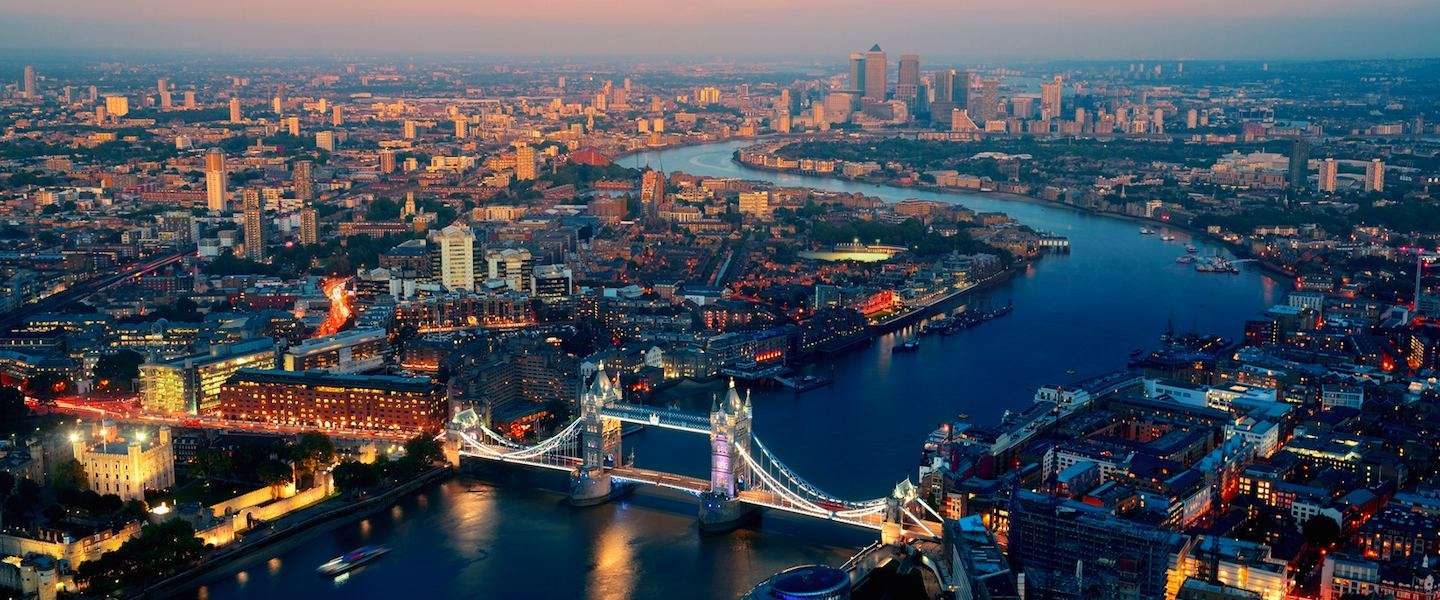

## Introduction
### Housing prediction in London
The topic of this notebook is the housing market of London in the years between 1995 and 2020.It contains exploratory data analysis and a section on price forecasting.

In [82]:
!pip install pystan --quiet
!pip install prophet --quiet
!pip install geopandas --quiet

In [83]:
# import libraries

import pandas as pd
import numpy as np

import missingno as msno
import statsmodels.api as sm

from prophet import Prophet

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12

# Allows to display all of the outputs of a cell
from IPython.display import display

# Set float data type format
pd.options.display.float_format = '{:,.2f}'.format

# Set the maximum number of row to be displayed
pd.options.display.max_rows = 999

# Set global visualisation settings
plt.rc('font', size=14)

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
%cd drive/MyDrive/MachineLearningProjects/LondonHousePriceForecast

[Errno 2] No such file or directory: 'drive/MyDrive/MachineLearningProjects/LondonHousePriceForecast'
/content/drive/MyDrive/MachineLearningProjects/LondonHousePriceForecast


<div class="alert alert-block alert-info">

## Read data into dataframes
Let's import the dataset and take a quick look at the data:


</div>

In [86]:
London_Monthly_df = pd.read_csv('./data/housing_in_london_monthly_variables.csv', parse_dates= ['date'])
London_Yearly_df  = pd.read_csv('./data/housing_in_london_yearly_variables.csv', parse_dates= ['date'])

<div class="alert alert-block alert-info">

### Exploratory Data Analysis (EDA)
#### Data Exploration



</div>

In [87]:
London_Monthly_df.head()

date            area  average_price       code  houses_sold  \
0 1995-01-01  city of london          91449  E09000001        17.00   
1 1995-02-01  city of london          82203  E09000001         7.00   
2 1995-03-01  city of london          79121  E09000001        14.00   
3 1995-04-01  city of london          77101  E09000001         7.00   
4 1995-05-01  city of london          84409  E09000001        10.00   

   no_of_crimes  borough_flag  
0           NaN             1  
1           NaN             1  
2           NaN             1  
3           NaN             1  
4           NaN             1

In [88]:
London_Monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           13549 non-null  datetime64[ns]
 1   area           13549 non-null  object        
 2   average_price  13549 non-null  int64         
 3   code           13549 non-null  object        
 4   houses_sold    13455 non-null  float64       
 5   no_of_crimes   7439 non-null   float64       
 6   borough_flag   13549 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 741.1+ KB


In [89]:
London_Monthly_df.describe()

average_price  houses_sold  no_of_crimes  borough_flag
count      13,549.00    13,455.00      7,439.00     13,549.00
mean      263,519.68     3,893.99      2,158.35          0.73
std       187,617.50    12,114.40        902.09          0.44
min        40,722.00         2.00          0.00          0.00
25%       132,380.00       247.00      1,623.00          0.00
50%       222,919.00       371.00      2,132.00          1.00
75%       336,843.00     3,146.00      2,582.00          1.00
max     1,463,378.00   132,163.00      7,461.00          1.00

In [90]:
London_Monthly_df.shape

(13549, 7)

<Axes: >

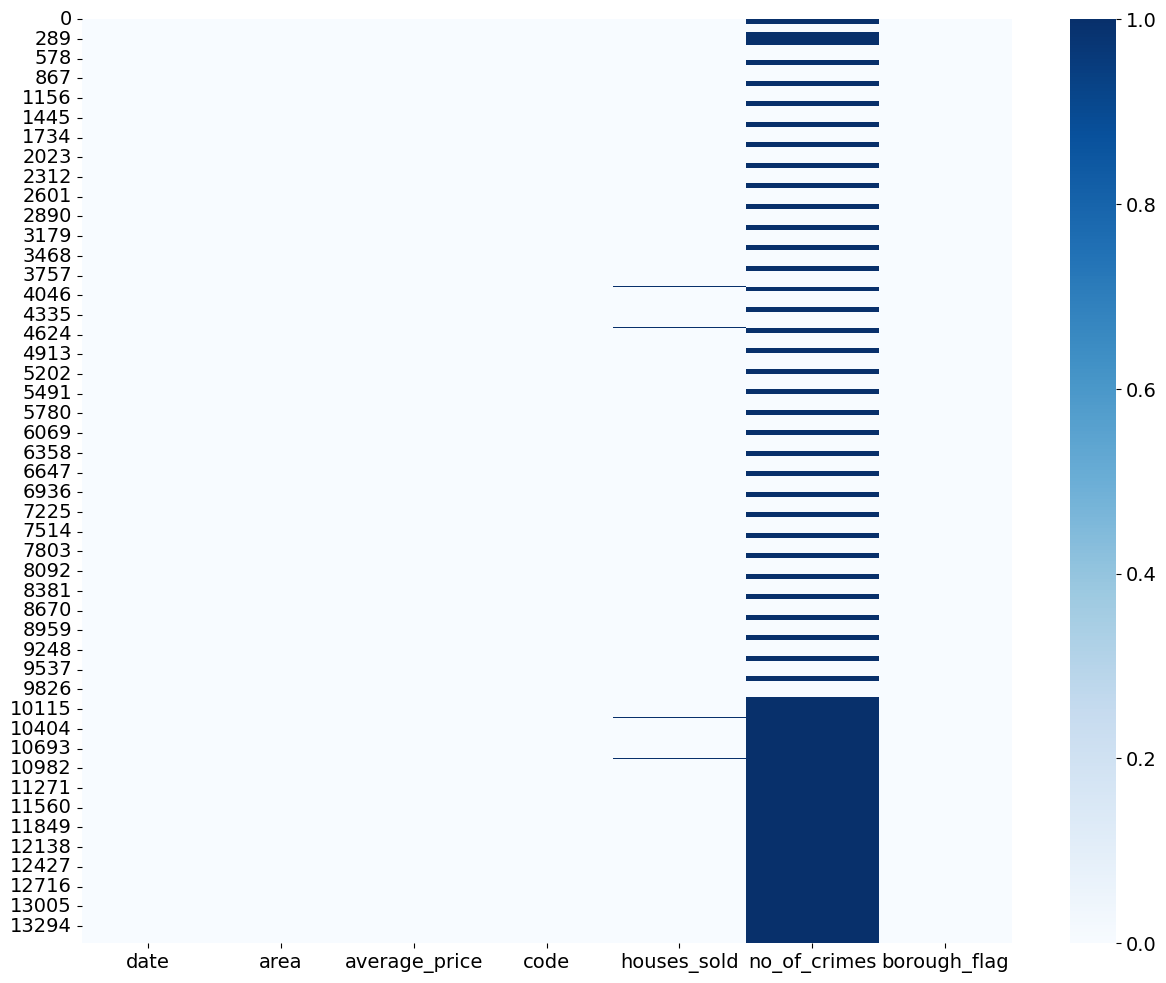

In [91]:
#Heatmap for all null values
sns.heatmap(London_Monthly_df.isnull(),cmap='Blues')

In [92]:
London_Monthly_df.isna().sum()

date                0
area                0
average_price       0
code                0
houses_sold        94
no_of_crimes     6110
borough_flag        0
dtype: int64

In [93]:
London_Yearly_df.head()

code                  area       date  median_salary  \
0  E09000001        city of london 1999-12-01      33,020.00   
1  E09000002  barking and dagenham 1999-12-01      21,480.00   
2  E09000003                barnet 1999-12-01      19,568.00   
3  E09000004                bexley 1999-12-01      18,621.00   
4  E09000005                 brent 1999-12-01      18,532.00   

   life_satisfaction mean_salary recycling_pct  population_size  \
0                NaN       48922             0         6,581.00   
1                NaN       23620             3       162,444.00   
2                NaN       23128             8       313,469.00   
3                NaN       21386            18       217,458.00   
4                NaN       20911             6       260,317.00   

   number_of_jobs  area_size  no_of_houses  borough_flag  
0             NaN        NaN           NaN             1  
1             NaN        NaN           NaN             1  
2             NaN        NaN           NaN             1  
3             NaN        NaN           NaN             1  
4             NaN        NaN           NaN             1

In [94]:
London_Yearly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   code               1071 non-null   object        
 1   area               1071 non-null   object        
 2   date               1071 non-null   datetime64[ns]
 3   median_salary      1049 non-null   float64       
 4   life_satisfaction  352 non-null    float64       
 5   mean_salary        1071 non-null   object        
 6   recycling_pct      860 non-null    object        
 7   population_size    1018 non-null   float64       
 8   number_of_jobs     931 non-null    float64       
 9   area_size          666 non-null    float64       
 10  no_of_houses       666 non-null    float64       
 11  borough_flag       1071 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 100.5+ KB


In [95]:
London_Yearly_df.shape

(1071, 12)

In [96]:
London_Yearly_df.isna().sum()

code                   0
area                   0
date                   0
median_salary         22
life_satisfaction    719
mean_salary            0
recycling_pct        211
population_size       53
number_of_jobs       140
area_size            405
no_of_houses         405
borough_flag           0
dtype: int64

In [97]:
London_Yearly_df.describe()

median_salary  life_satisfaction  population_size  number_of_jobs  \
count       1,049.00             352.00         1,018.00          931.00   
mean       27,977.79               7.49     6,042,576.49    3,188,094.52   
std         6,412.81               0.20    15,268,096.56    8,058,302.24   
min        15,684.00               7.00         6,581.00       47,000.00   
25%        23,857.00               7.35       224,345.75       94,500.00   
50%        27,441.00               7.51       294,603.50      157,000.00   
75%        30,932.00               7.64     4,630,098.50    2,217,000.00   
max        61,636.00               7.96    66,435,550.00   35,750,000.00   

          area_size  no_of_houses  borough_flag  
count        666.00        666.00      1,071.00  
mean     372,490.27    881,468.15          0.65  
std    2,157,060.24  3,690,376.14          0.48  
min          315.00      5,009.00          0.00  
25%        2,960.00     87,635.50          0.00  
50%        4,323.00    102,402.00          1.00  
75%        8,220.00    126,276.00          1.00  
max   13,303,728.00 24,172,166.00          1.00

<Axes: >

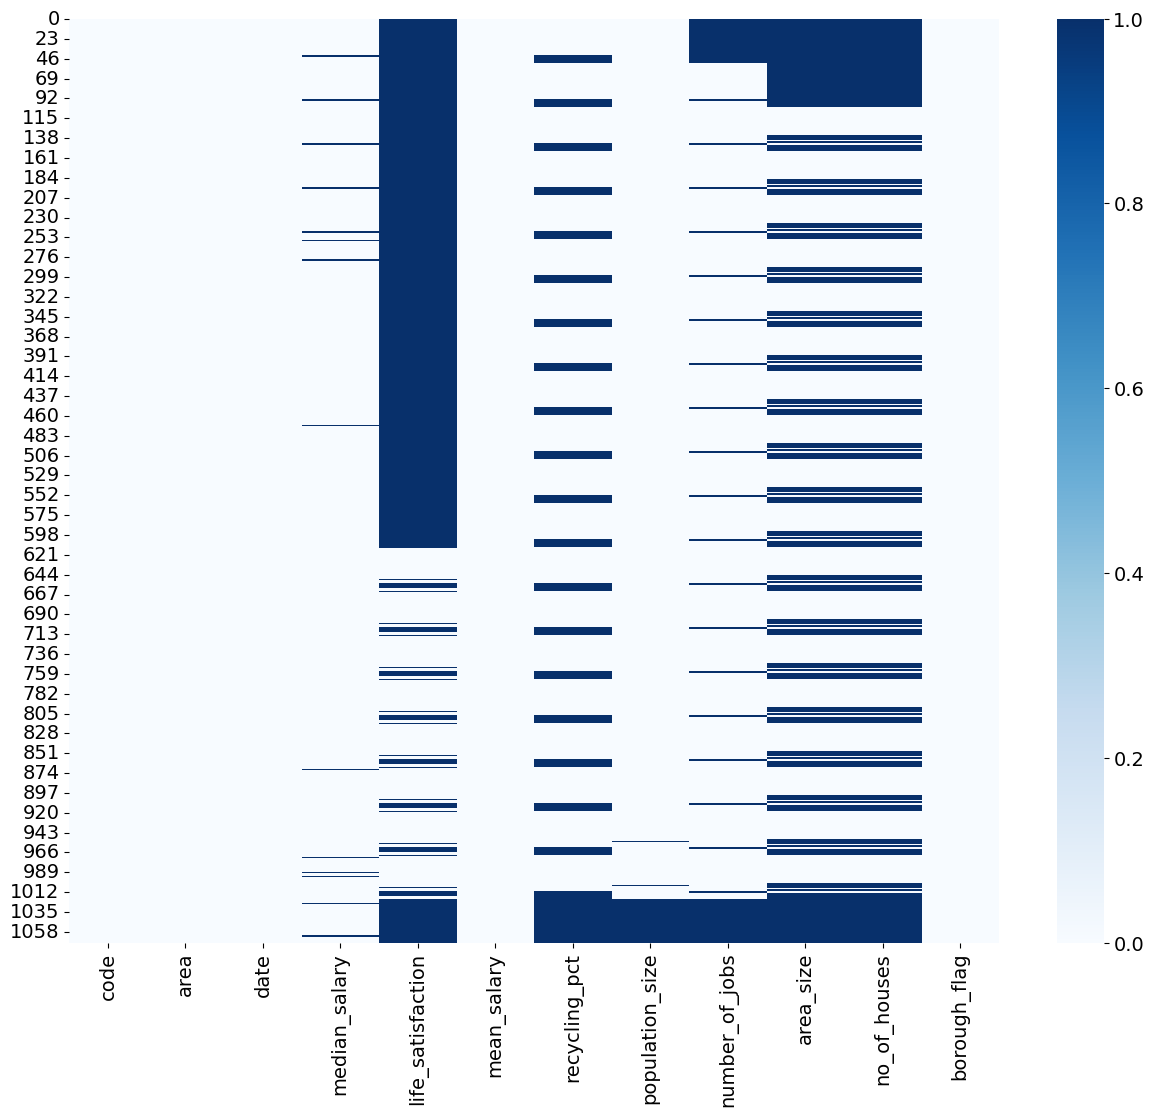

In [98]:
#Heatmap for all null values
sns.heatmap(London_Yearly_df.isnull(),cmap='Blues')

Observations:
* Yearly data is missing a few **'houses_sold'** values
* Many values are missing for the **'no_of_crimes'** variable

## Data Cleaning

In [99]:
#@title filling in NaN values for crimes with the overall average.
mean = London_Monthly_df['no_of_crimes'].mean()
London_Monthly_df['no_of_crimes'].fillna(mean, inplace=True)

In [100]:
#@title Fill NULL with mean based on area
London_Monthly_df['houses_sold'].fillna(London_Monthly_df.groupby('area')['houses_sold'].transform('mean'), inplace = True)

In [101]:
London_Monthly_df.isna().sum()

date             0
area             0
average_price    0
code             0
houses_sold      0
no_of_crimes     0
borough_flag     0
dtype: int64

Observations:
* London_Monthly_df data completly cleaned

In [102]:
df   = London_Monthly_df.copy()
df_1 = London_Yearly_df.copy()

#Feature Engineering

In [103]:

London_Monthly_df['revenue'] = London_Monthly_df['average_price']*London_Monthly_df['houses_sold']
London_Monthly_df.sample(3)

date            area  average_price       code  houses_sold  \
9051 1996-05-01  waltham forest          61075  E09000031       288.00   
8157 1997-01-01       southwark          73822  E09000028       249.00   
6485 2008-03-01         lambeth         304300  E09000022       319.00   

      no_of_crimes  borough_flag       revenue  
9051      2,158.35             1 17,589,600.00  
8157      2,158.35             1 18,381,678.00  
6485      2,772.00             1 97,071,700.00

# Data Visualization

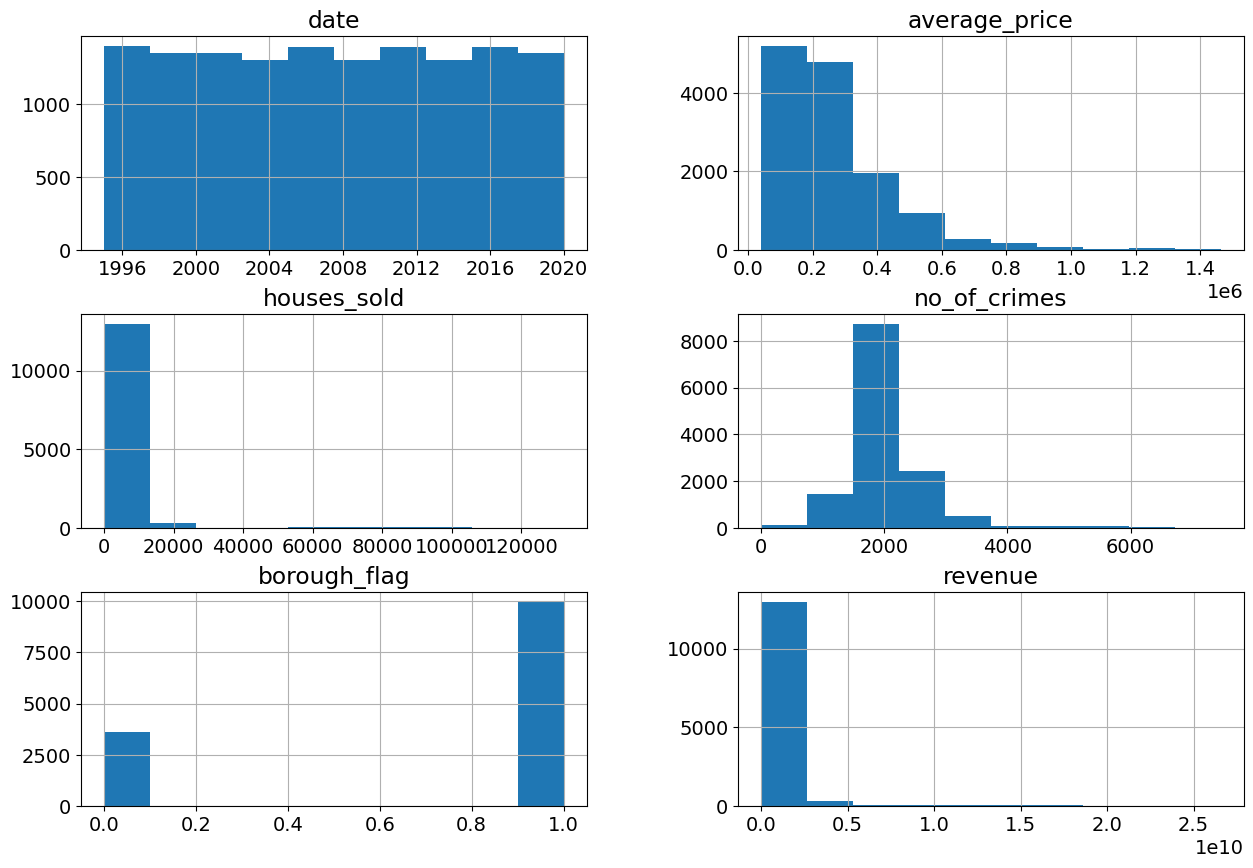

In [104]:
#@title London Monthly data histogram
London_Monthly_df.hist(figsize=(15,10))
plt.show()

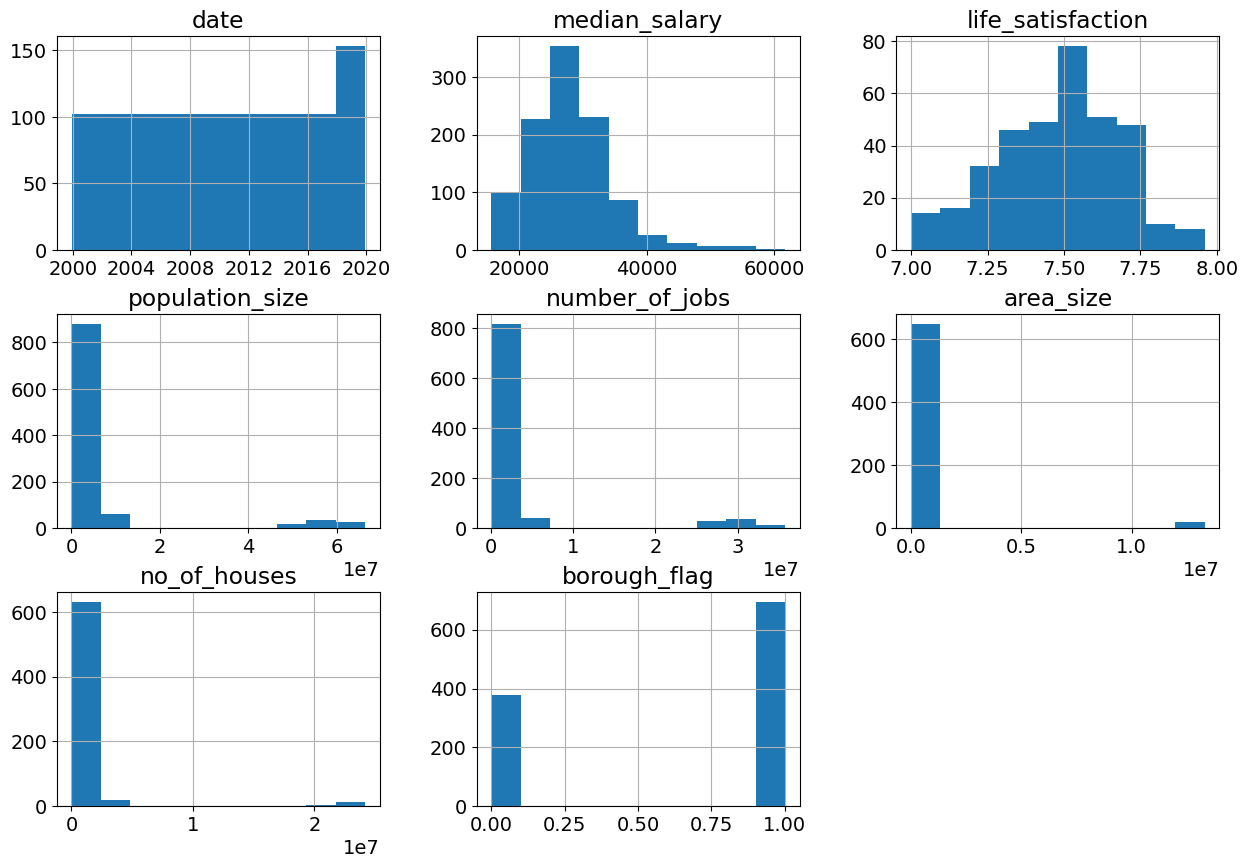

In [105]:
London_Yearly_df.hist(figsize=(15,10))
plt.show()

In [106]:
#@title Boxplot of average price
fig = px.box(London_Monthly_df, x="average_price", template = 'simple_white', title ='Average house price (1995 - 2020)',
              width=700, height=500 , color= 'borough_flag')
fig.show()

In [107]:
#@title Total houses sold
fig = px.histogram(London_Monthly_df, x="average_price", y="houses_sold", template = 'simple_white', title ='Total houses sold (1995 - 2020)',
              width=700, height=500 , color= 'borough_flag', nbins = 20)
fig.update_traces(opacity=0.75)
fig.show()

total_houses_sold = round(London_Monthly_df.groupby('borough_flag')['houses_sold'].sum()/1000000,1)
total_houses_sold.to_frame(name = 'Total houses sold (Million)')

Total houses sold (Million)
borough_flag                             
0                                   49.60
1                                    3.20

In [108]:
#@title Price changes over 25 years
df_date_price = London_Monthly_df.groupby(['date','borough_flag'])['average_price'].mean().to_frame().reset_index()
fig = px.line(df_date_price, x='date', y= 'average_price' , template = 'simple_white', title ='The change of house prices over 25 years',
              width=800, height=400 , color = 'borough_flag',color_discrete_sequence=["orange", "steelblue"],
              category_orders={"borough_flag": ["0", "1"]}  )
fig.show()

In [109]:
#@title Most expensive area in Boroughs
# Look into mean average price houses in each area of borough
df_boroughs = London_Monthly_df[London_Monthly_df['borough_flag'] == 1]
df_boroughs_mean = round(df_boroughs.groupby('area')['average_price'].mean(),2).sort_values().to_frame().reset_index()

# plotting the bar chart
fig = px.bar(df_boroughs_mean, x="average_price", y="area", template = 'simple_white', title ='Which borough area is the most expensive ?',
              width=800, height=1000 , orientation = 'h' )
fig.update_traces(opacity=0.75)
fig.show()

In [110]:
#@title Most Houses sold in boroughs
df_boroughs_sold_sum = df_boroughs.groupby('area')['houses_sold'].sum().sort_values().to_frame().reset_index()

fig = px.bar(df_boroughs_sold_sum, x="houses_sold", y="area", template = 'simple_white', title ='How many houses sold in London boroughs?',
              width=800, height=1000 , orientation = 'h' )
fig.update_traces(opacity=0.75)
fig.show()

Text(0.5, 1.0, 'Crime rate over the Years')

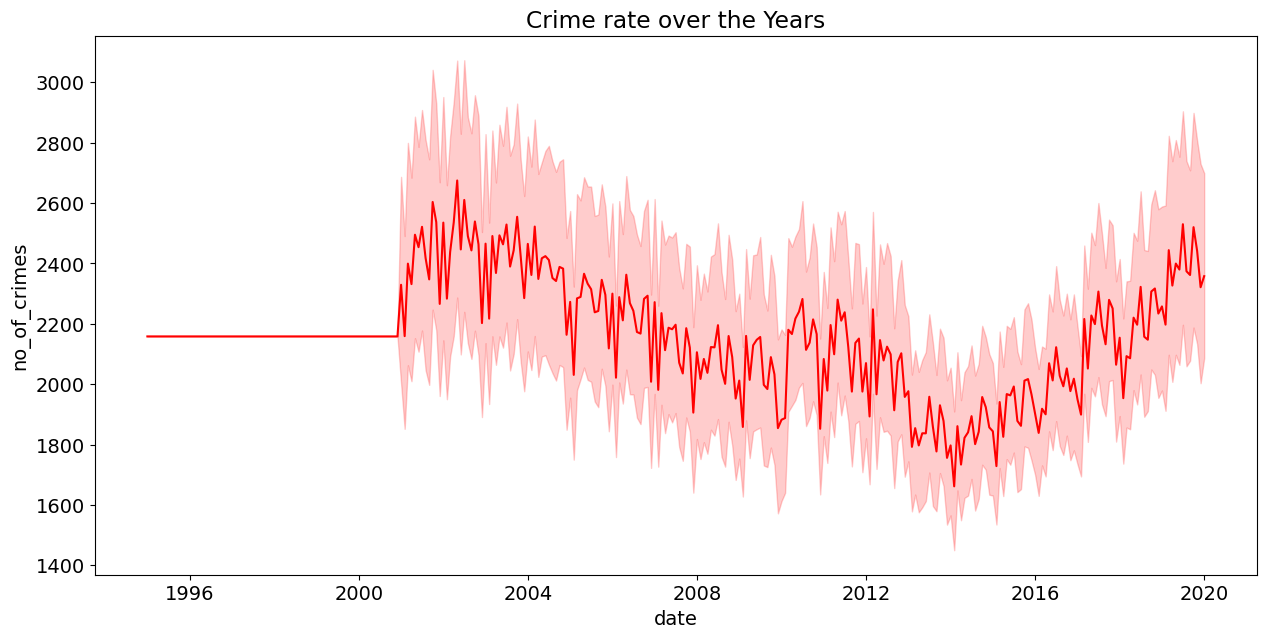

In [111]:
#@title Crime rate over the Years in boroughs
plt.figure(figsize=(15,7))
sns.lineplot(x= 'date', y='no_of_crimes', data= df_boroughs, color = 'r')
plt.title("Crime rate over the Years")

The observation has some interesting points, let's discuss them

From 1995 to 2020

* Most expensive area in Boroughs are kensington and chelsea and westminester

* The most sold houses in the boroughs are in Wandsworth

* Cheepest area in Boroughs are barking and degenhan and bexley

* The average house prices in London boroughs has dramatically been increased. The price has grown from around 82K pounds to around 528K pounds over 25 years. The house prices in boroughs are extremely varying.The minimum is 50K while the maximum can goes up to around 1.5 Million pounds !!

* Meanwhile the average house prices outside London has been gradually increased. It has grown slowly around 57K pounds to around 290K pounds which is almost 1.8 times less than average price in London Borough !!

The houses sold of outside London are outnumbered London boroughs.

* Total houses sold in London boroughs ≈ 3.2 Million

* Total houses sold outside London ≈ 49.6 Million

In [112]:
YearlyData_analysis = London_Yearly_df.copy()
YearlyData_analysis.sample(3)

code                  area       date  median_salary  \
82   E09000032            wandsworth 2000-12-01      22,840.00   
701  E12000006                  east 2012-12-01      26,145.00   
332  E09000027  richmond upon thames 2005-12-01      26,809.00   

     life_satisfaction mean_salary recycling_pct  population_size  \
82                 NaN       26862             7       267,695.00   
701                NaN       30899            49     5,907,348.00   
332                NaN       30298            29       181,508.00   

     number_of_jobs  area_size  no_of_houses  borough_flag  
82       127,000.00        NaN           NaN             1  
701    2,869,000.00        NaN           NaN             0  
332       88,000.00   5,876.00     79,877.00             1

In [113]:
YearlyData_analysis['year'] = YearlyData_analysis['date'].dt.year
YearlyData_analysis['month']= YearlyData_analysis['date'].dt.month

In [114]:
YearlyData_analysis.sample(5)

code                    area       date  median_salary  \
593  E09000033             westminster 2010-12-01      37,836.00   
143  E12000009              south west 2001-12-01      18,465.00   
571  E09000011               greenwich 2010-12-01      31,821.00   
628  E09000017              hillingdon 2011-12-01      33,589.00   
624  E09000013  hammersmith and fulham 2011-12-01      36,143.00   

     life_satisfaction mean_salary recycling_pct  population_size  \
593                NaN       56080            25       217,187.00   
143                NaN       21524            17     4,943,364.00   
571                NaN       34526            37       249,171.00   
628               7.40       39436            43       275,499.00   
624               7.38       42531            30       182,445.00   

     number_of_jobs  area_size  no_of_houses  borough_flag  year  month  
593      644,000.00   2,203.00    116,644.00             1  2010     12  
143    2,543,000.00        NaN           NaN             0  2001     12  
571       82,000.00   5,044.00    102,651.00             1  2010     12  
628      202,000.00  11,570.00    103,907.00             1  2011     12  
624      140,000.00   1,715.00     82,390.00             1  2011     12

In [115]:
#@title What is the maximum and minimum average price per year in borough
YearlyData_analysis_borough = YearlyData_analysis[YearlyData_analysis['borough_flag'] == 1]
Max_salary = YearlyData_analysis_borough.groupby('area').median_salary.max().head(5)
Max_salary

area
barking and dagenham   33,131.00
barnet                 32,623.00
bexley                 31,642.00
brent                  31,739.00
bromley                30,861.00
Name: median_salary, dtype: float64

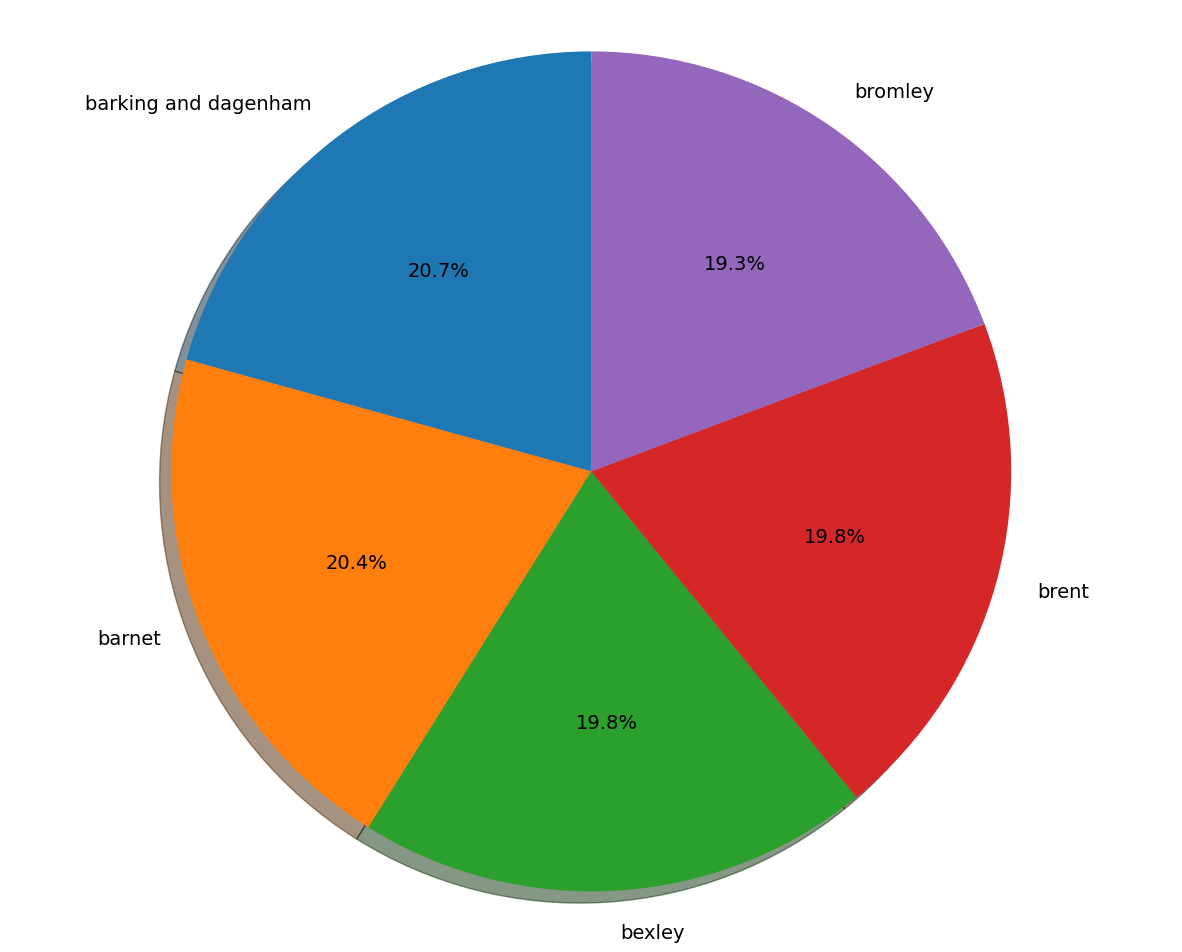

In [116]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'barking and dagenham', 'barnet', 'bexley', 'brent' , 'bromley'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(Max_salary, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [117]:
#@title MaxPopulation size in borough area
MaxPopulation_size = YearlyData_analysis_borough.groupby('area').population_size.max().head(5)
MaxPopulation_size

area
barking and dagenham   211,998.00
barnet                 392,140.00
bexley                 247,258.00
brent                  330,795.00
bromley                331,096.00
Name: population_size, dtype: float64

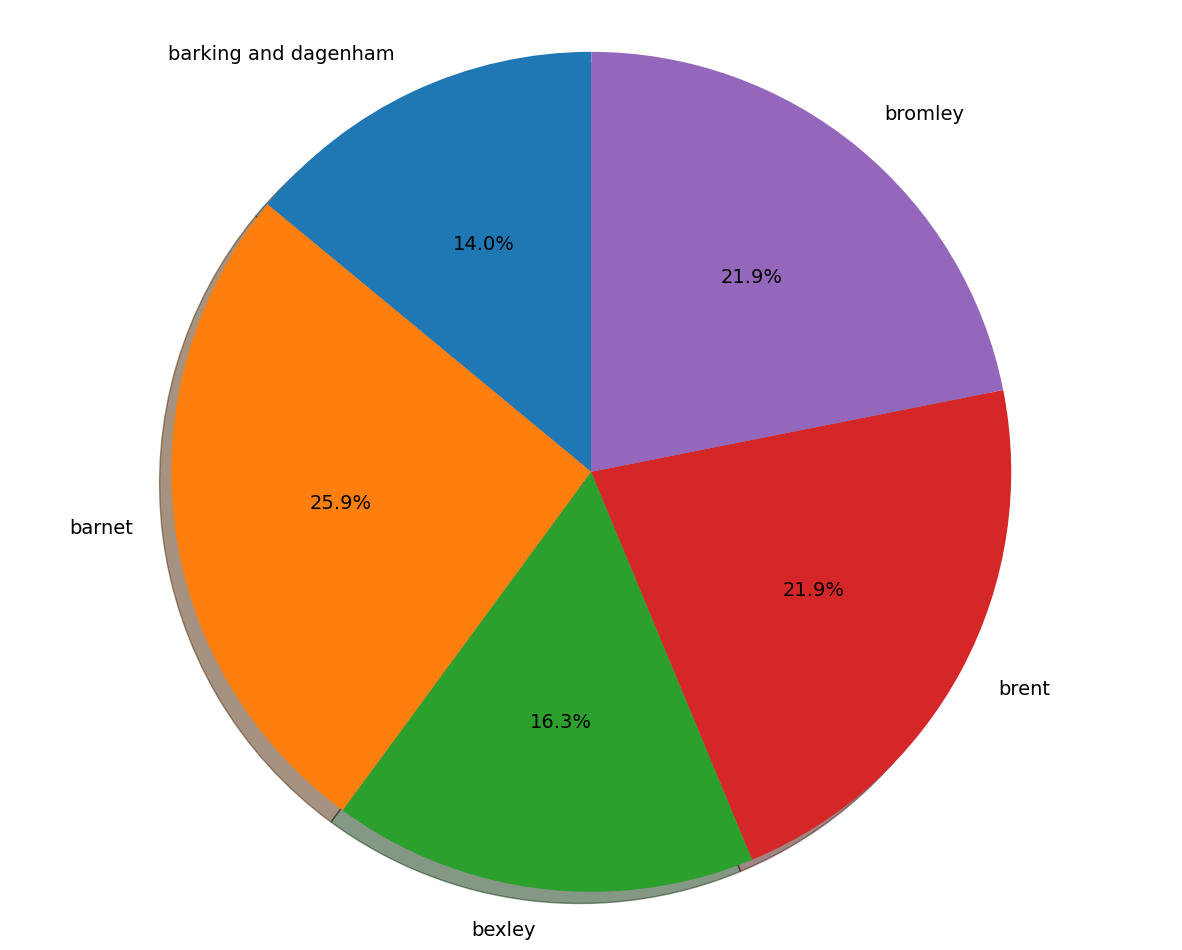

In [118]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'barking and dagenham', 'barnet', 'bexley', 'brent' , 'bromley'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(MaxPopulation_size, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [119]:
#houses sold Prediction

In [120]:
#Time Series Forecasting with XGBoost

In [121]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [122]:
LondonMonthly_TS_df  = London_Monthly_df.copy()
LondonMonthly_TS_df.sample(3)

date             area  average_price       code  houses_sold  \
779   2009-10-01           barnet         309970  E09000003       395.00   
12213 2009-01-01  east of england         175528  E12000006     3,100.00   
2578  2009-03-01           ealing         251130  E09000009       116.00   

       no_of_crimes  borough_flag        revenue  
779        2,222.00             1 122,438,150.00  
12213      2,158.35             0 544,136,800.00  
2578       2,791.00             1  29,131,080.00

In [123]:
#Convert our data to timeseries
LondonMonthly_TS_df = LondonMonthly_TS_df.set_index(LondonMonthly_TS_df['date'])
del LondonMonthly_TS_df['date']
LondonMonthly_TS_df.head(5)

area  average_price       code  houses_sold  \
date                                                                
1995-01-01  city of london          91449  E09000001        17.00   
1995-02-01  city of london          82203  E09000001         7.00   
1995-03-01  city of london          79121  E09000001        14.00   
1995-04-01  city of london          77101  E09000001         7.00   
1995-05-01  city of london          84409  E09000001        10.00   

            no_of_crimes  borough_flag      revenue  
date                                                 
1995-01-01      2,158.35             1 1,554,633.00  
1995-02-01      2,158.35             1   575,421.00  
1995-03-01      2,158.35             1 1,107,694.00  
1995-04-01      2,158.35             1   539,707.00  
1995-05-01      2,158.35             1   844,090.00

In [124]:
# Set date as index for easier manipulation
df = df.set_index(pd.to_datetime(df['date']))
df_1 = df_1.set_index(pd.to_datetime(df_1['date']))

del df['date']
del df_1['date']

df_1['mean_salary'] = df_1['mean_salary'].replace('-', np.NaN)
df_1['mean_salary'] = df_1['mean_salary'].replace('#', np.NaN)
df_1['mean_salary'] = df_1['mean_salary'].astype(float)

# Create dataset cuts
prices_london = df[df['borough_flag'] == 1]
prices_england = df[df['area'] == 'england']
prices_north_east = df[df['area'] == 'north east']

# Calcualte mean prices for the different cuts of data
london_mean_price = prices_london.groupby('date')['average_price'].mean()
england_mean_price = prices_england.groupby('date')['average_price'].mean()
north_east_mean_price = prices_north_east.groupby('date')['average_price'].mean()

print('Processing Complete')

Processing Complete


### 3.1 Main Variable Analysis

In [125]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=london_mean_price.index,
                         y=london_mean_price.values,
                         mode='lines',
                         name='London Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=england_mean_price.index,
                         y=england_mean_price.values,
                         mode='lines',
                         name='England Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=north_east_mean_price.index,
                         y=north_east_mean_price.values,
                         mode='lines',
                         name='North East Mean House Price',
                        ))


fig.update_layout(
    template='gridon',
    title='Average Monthly House Price',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    legend=dict(y=-.2, orientation='h'),
    shapes=[
        dict(
            type="line",
            x0='2016-06-01',
            x1='2016-06-01',
            y0=0,
            y1=london_mean_price.values.max()*1.2,
            line=dict(
            color="LightSalmon",
            dash="dashdot"
            )
        ),
        dict(
            type="rect",
            x0="2007-12-01",
            y0=0,
            x1="2009-06-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
        dict(
            type="rect",
            x0="2001-03-01",
            y0=0,
            x1="2001-11-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ],
    annotations=[
            dict(text="The Great Recession", x='2007-12-01', y=london_mean_price.values.max()*1.2),
            dict(text="Brexit Vote", x='2016-06-01', y=london_mean_price.values.max()*1.2),
            dict(text="Dot-Com Bubble Recession", x='2001-03-01', y=london_mean_price.values.max()*1.2)
    ]
)

fig.show()

London's house prices are well above average when compared to England's. Furthermore, it dwarfs the prices of the relatively poor North East region.

It is clear that the global recession in 2008 has made a radical adjustment to the overall house prices, however, this was only temporary and London's house prices have rebounded since. The Brexit vote in 2016 has not impacted the prices in a significant way, but the price growth has plateaued.

As expected, the recession that followed the dot-com bubble had no material impact on UK's house prices. This is because this particular recession was mostly concentrated in the USA.

In [126]:
fig = px.line(prices_london, x=prices_london.index, y="average_price", color='area')

fig.update_layout(
    template='gridon',
    title='Average Monthly London House Price by Borough',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

London has 33 boroughs (including City of London). Visually, this makes the exploration of the graph difficult. Luckily, Plotly allows to dynamically explore the data. You can click on area to hide it or double click to hide all other areas. Some key observations:
* Kensington and Chelsea historically has been and remains the most expensive borough to buy a house in
* The more expensive boroughs have greater volatility in average price
* Brent had a significant decline in house prices since 2019

In [127]:
# Calculate the mean yearly price per borough
yearly_prices_london = prices_london.groupby('area').resample('y')['average_price'].mean()

# Calculate the yealy average price percentage change
yearly_prices_london_pct_ch = yearly_prices_london.groupby(level='area').apply(lambda x: x.pct_change())

yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.unstack()
yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.iloc[::-1]

del yearly_prices_london_pct_ch['1995-12-31']

<ipython-input-127-2a9589649077>:5: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [128]:
fig = go.Figure(data=go.Heatmap(
        z=yearly_prices_london_pct_ch.values,
        x=yearly_prices_london_pct_ch.columns,
        y=yearly_prices_london_pct_ch.index,
        colorscale='Cividis'))

fig.update_layout(
    title='YoY Average London House Price Percentage Change',
    title_x=0.5,
    yaxis_nticks=33,
    xaxis_title='Year',
    yaxis_title='Borough'
)

fig.show()

A heatmap provides an interesting way to analyze the changes in house prices. The year 2000 has seen the sharpest house price rise. The mid '10 have also seen the prices trending upwards, but they have been relatively stable / decreasing since.

In [129]:
# Load the shape file for mapping
map_df = gpd.read_file('./London_Wards/Boroughs/London_Borough_Excluding_MHW.shp')

map_df = map_df[['NAME', 'geometry']]
map_df = map_df.rename(columns={'NAME': 'area'})
map_df['area'] = map_df['area'].str.lower()
map_df['area'] = map_df['area'].str.replace('&','and')

yearly_prices_london_df_map = pd.DataFrame(yearly_prices_london)
yearly_prices_london_df_map = yearly_prices_london_df_map.reset_index()

price_map = map_df.set_index('area').join(yearly_prices_london_df_map.set_index('area'))
price_map = price_map.reset_index()

price_map = price_map[price_map['date'] == '2019-12-31']

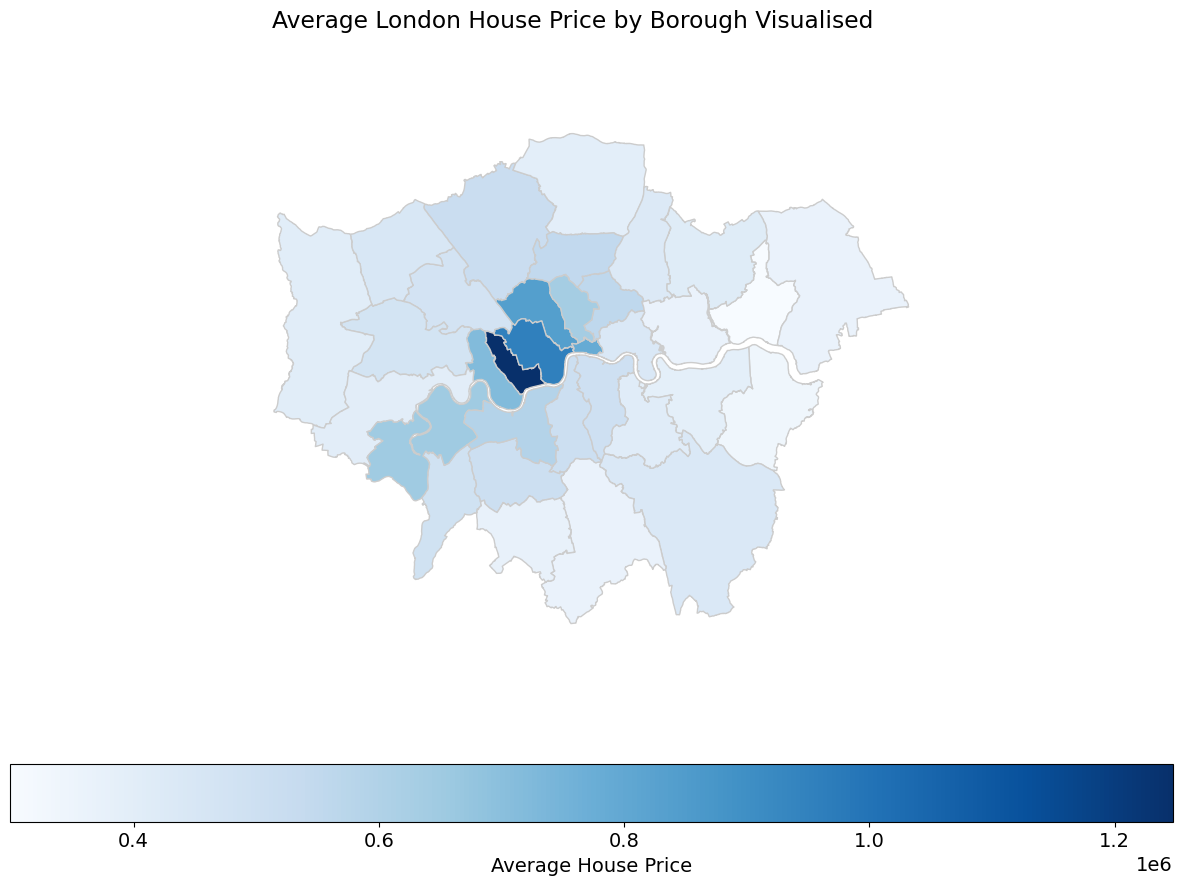

In [130]:
variable = 'average_price'

fig, ax = plt.subplots(1, figsize=(15, 10))
price_map.plot(column=variable,
               cmap='Blues',
               linewidth=1,
               ax=ax,
               edgecolor='0.8',
               legend=True,
               legend_kwds={'label': "Average House Price",
                           'orientation': "horizontal"})
ax.axis('off')
plt.suptitle('Average London House Price by Borough Visualised')
plt.show()

The map nicely illustrates that West London tends to be a much more expensive place to live than East London.

### 3.2 Additional Variable Exploration

In [131]:
london_mean_values = prices_london.groupby('area').resample('y').mean().reset_index()
df_1 = df_1.groupby('area').resample('y').mean().reset_index()
london_mean_values = pd.merge(london_mean_values, df_1, on=['area', 'date'], how='left')

del london_mean_values['borough_flag_x']
del london_mean_values['borough_flag_y']

<ipython-input-131-4067f391daff>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-131-4067f391daff>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-131-4067f391daff>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-131-4067f391daff>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to

<ipython-input-132-bb9866eb8db2>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-132-bb9866eb8db2>:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



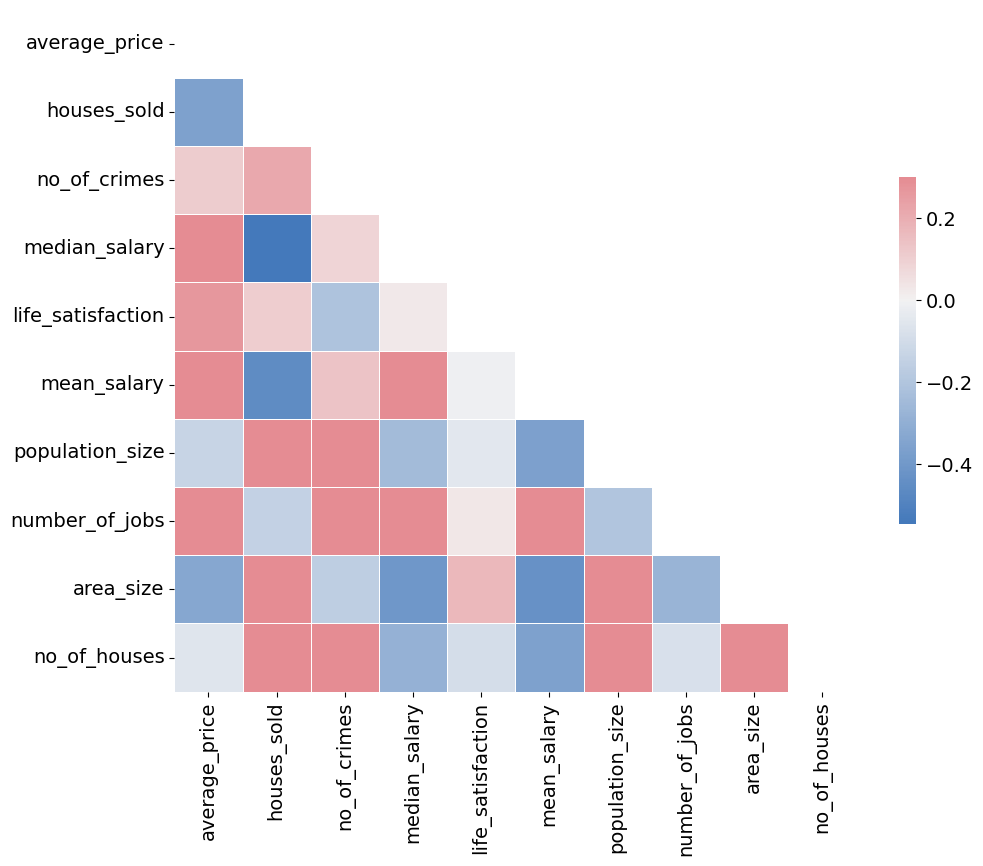

In [132]:
# Compute the correlation matrix
corr = london_mean_values.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

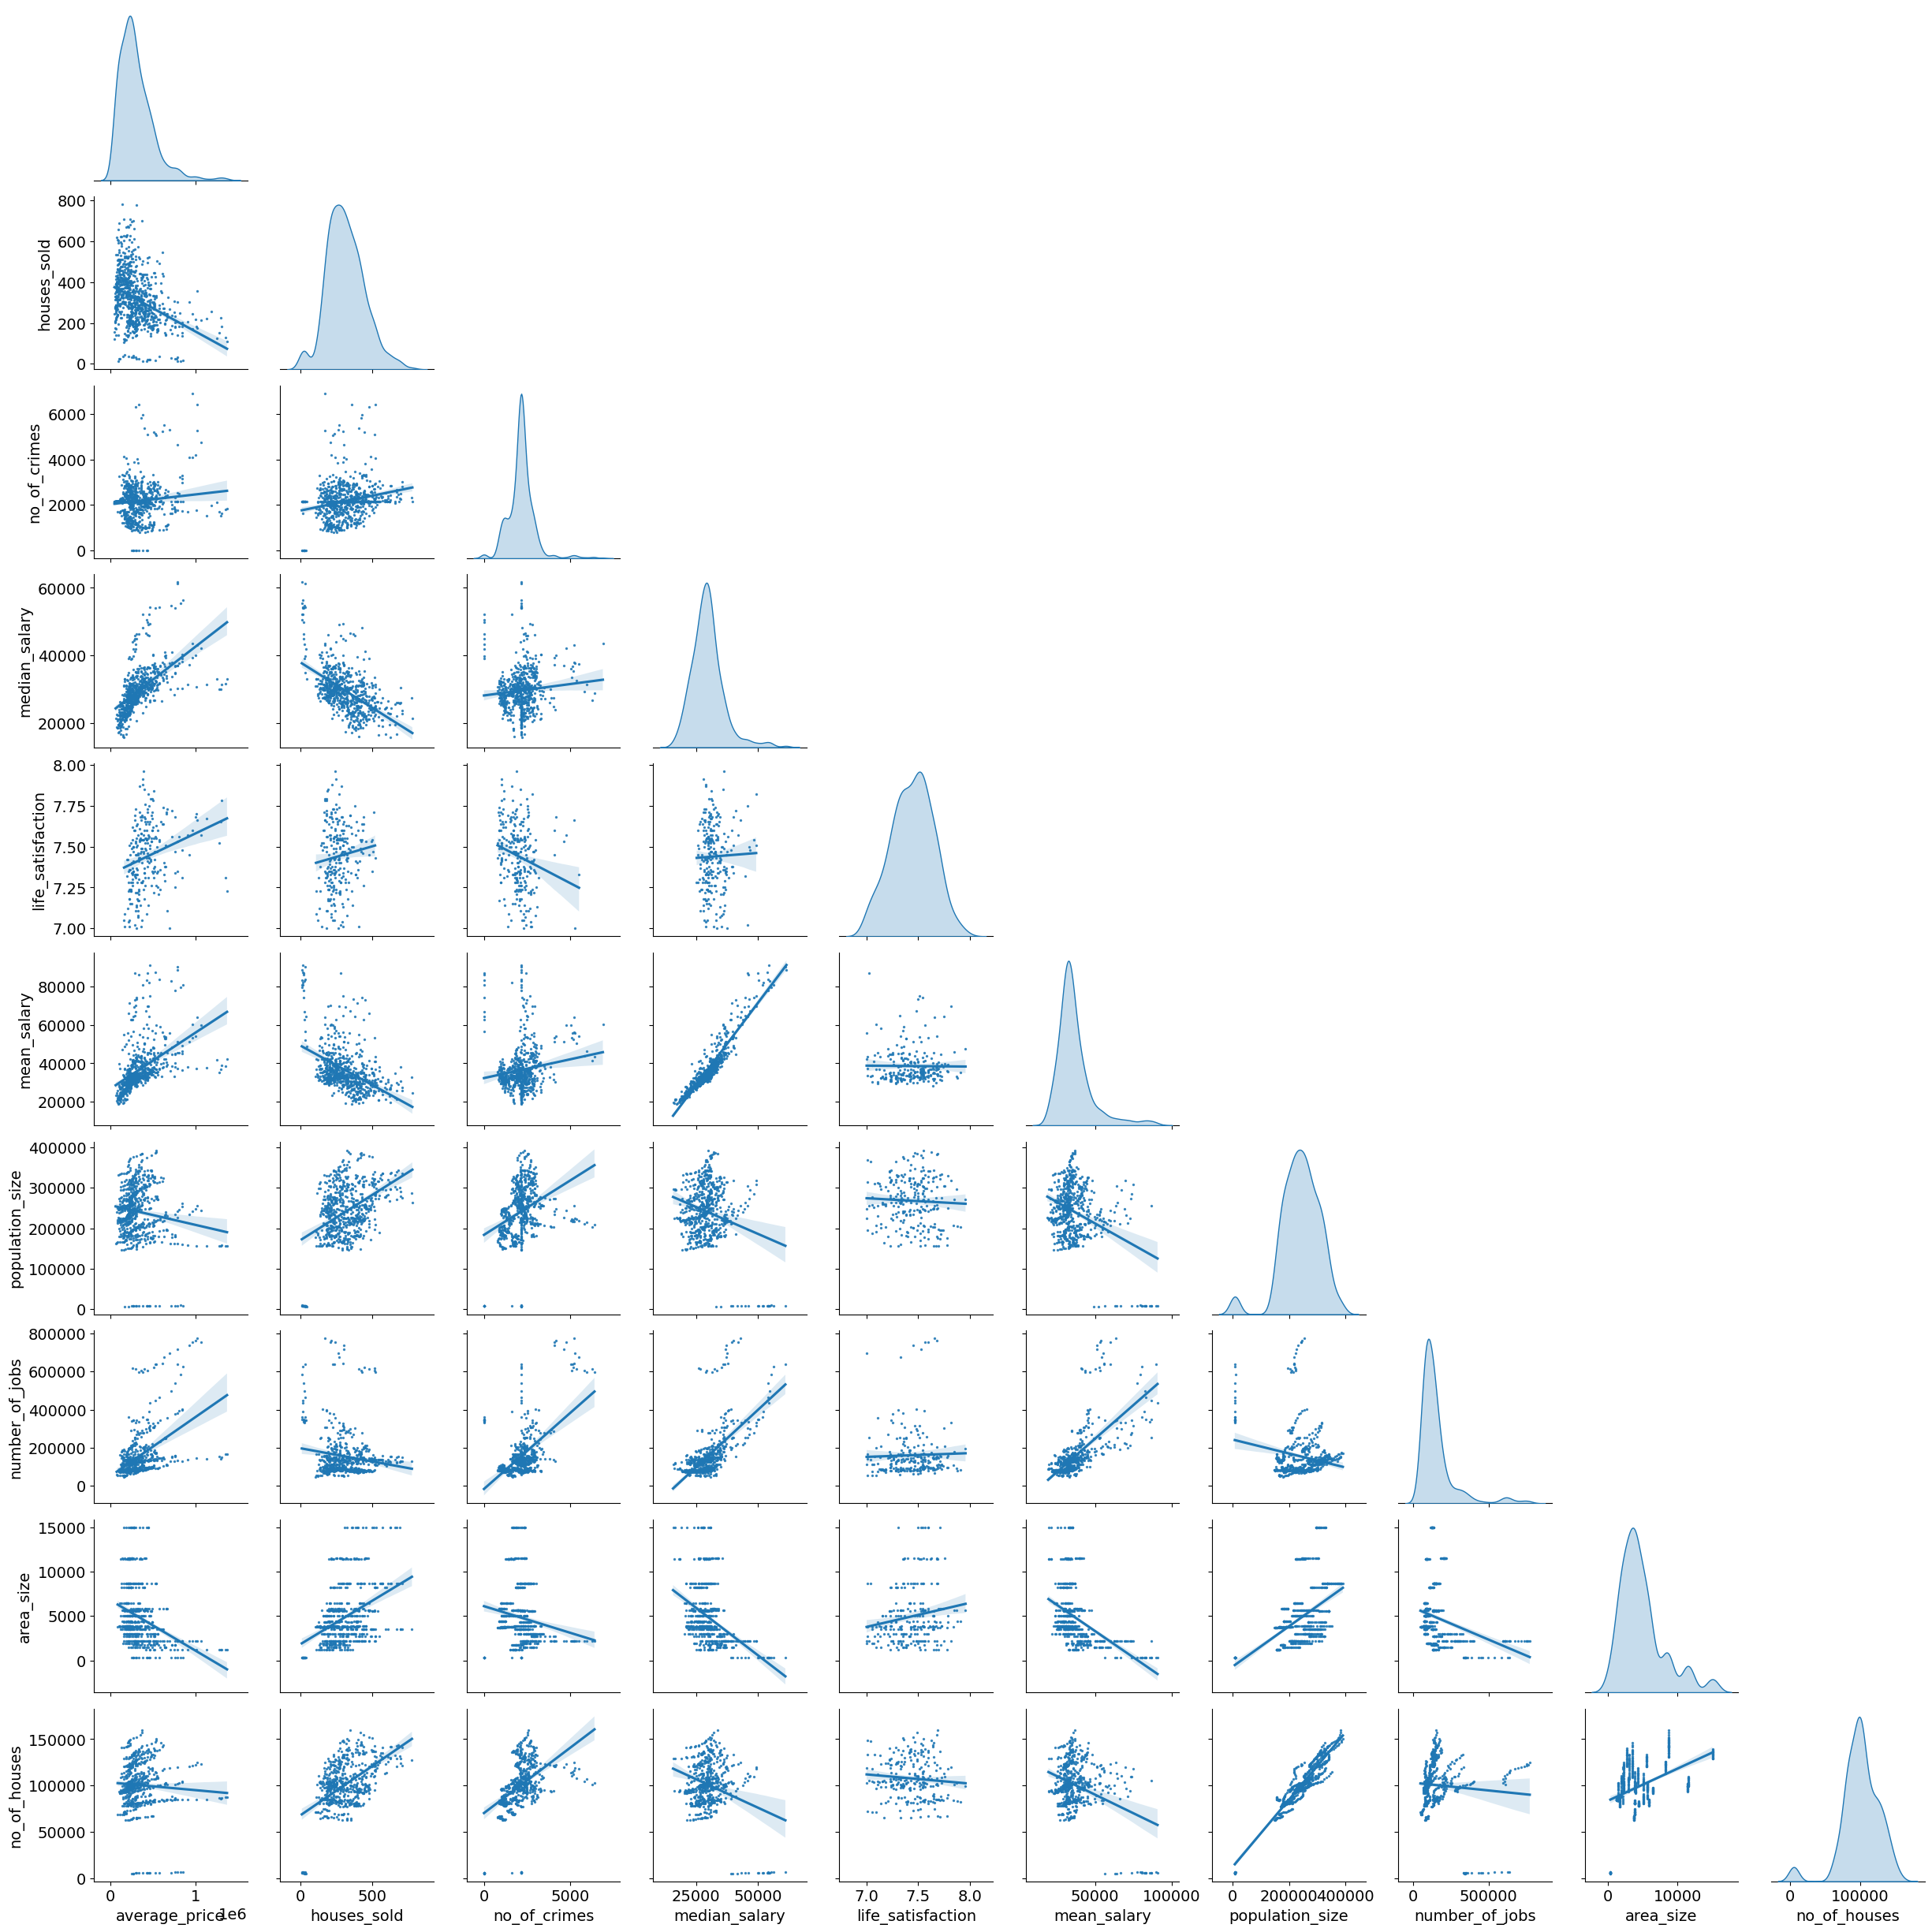

In [133]:
sns.pairplot(london_mean_values, corner=True, kind='reg', diag_kind='kde', plot_kws=dict(scatter_kws=dict(s=2)))
plt.show()

Not surprisingly, it seems that average house price has the highest positive correlation with the median and mean salaries of the borough's residents. This makes sense, as higher earners will be able to afford more expensive neighborhoods. However, this can have negative effects, as it leads to [gentrification](https://en.wikipedia.org/wiki/Gentrification) and loss of affordable housing.

## 4. House Prices Prediction <a id="4"></a>

This part of the notebook explores the various different ways how London's house prices can be predicted.

Before we dive into the models, let's decompose the time series data. This is done to explore the variety of patters that the data shows.

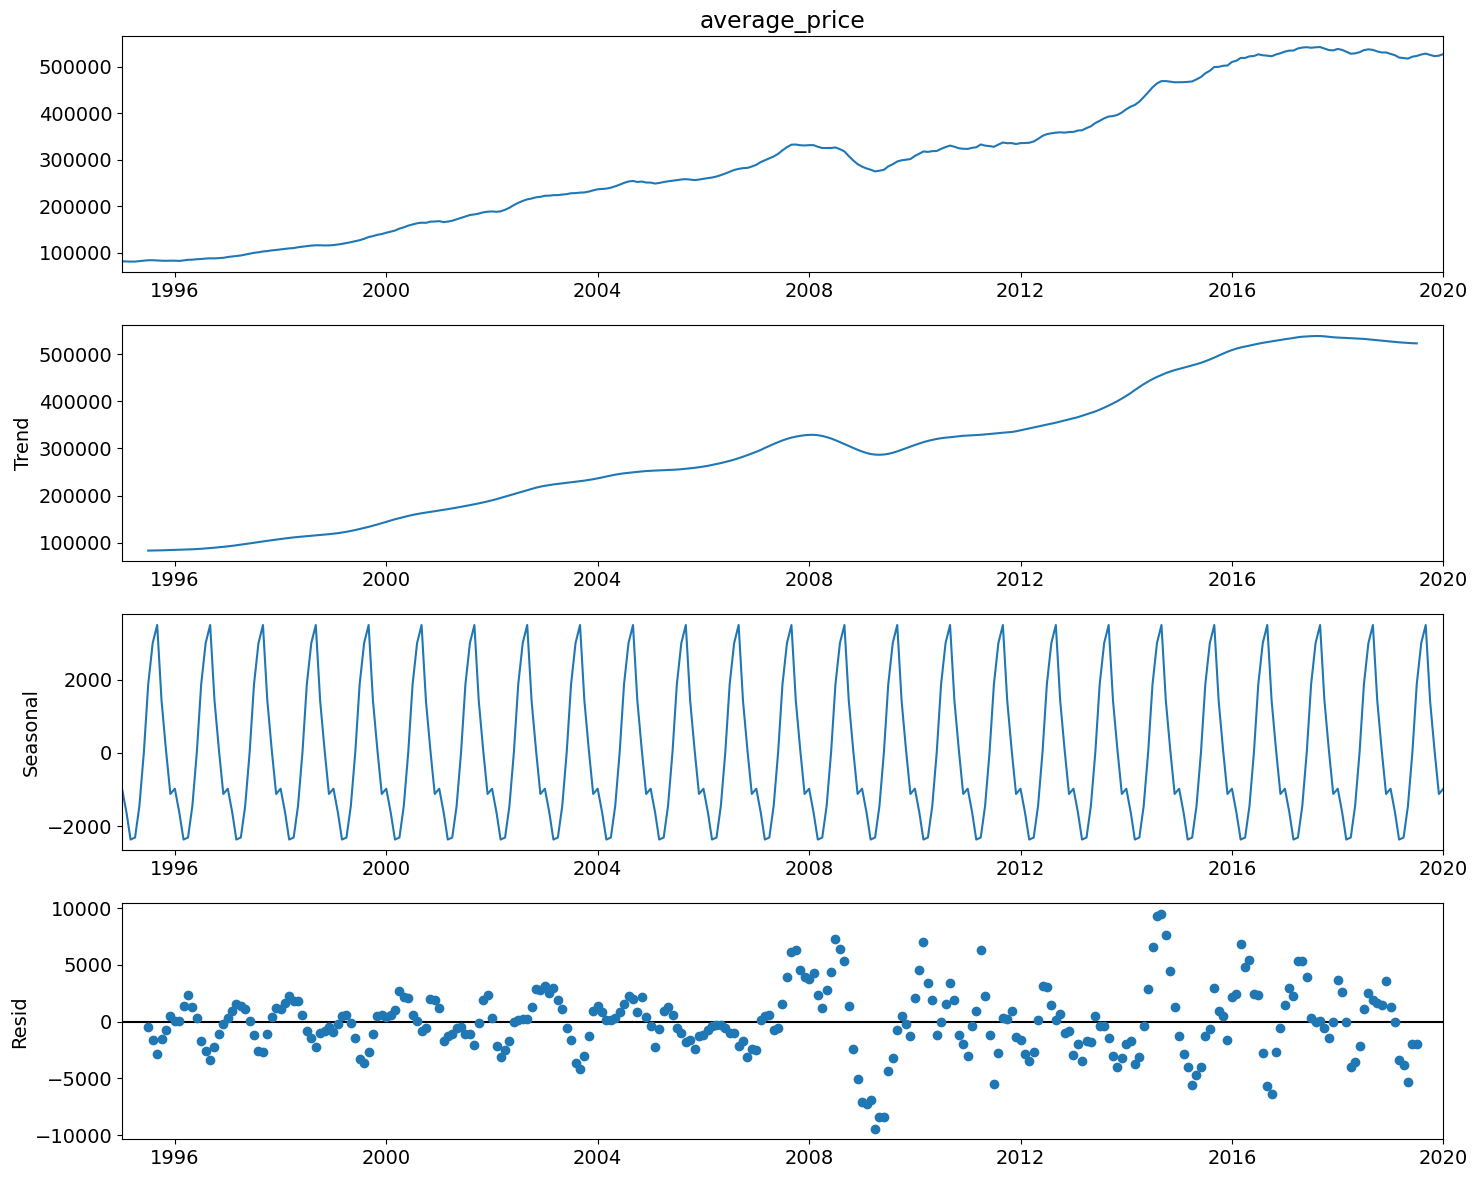

In [134]:
decomposition = sm.tsa.seasonal_decompose(london_mean_price, model='additive')
fig = decomposition.plot()
plt.show()

### 4.1 Prophet Model

Prophet is an open source forcasting tool developed by Facebook Core Data Science team. It is available in Python and R. Facebook's team pitches Prophet as: fast, accurate, robust to outliers and intuitively tunable.

Official documentation of the tool can be found [here](https://facebook.github.io/prophet/).

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_y8zzhl/qu93ef7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_y8zzhl/2wptvj2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4617', 'data', 'file=/tmp/tmpe_y8zzhl/qu93ef7i.json', 'init=/tmp/tmpe_y8zzhl/2wptvj2j.json', 'output', 'file=/tmp/tmpe_y8zzhl/prophet_modelkp13uygr/prophet_model-20230618204820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


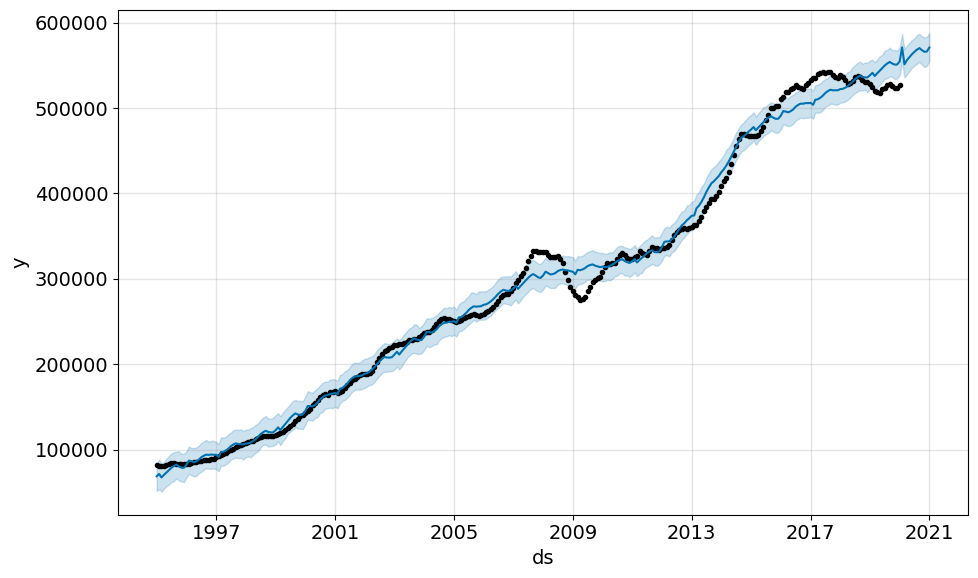

In [135]:
# Prepare the
model_df = pd.DataFrame(london_mean_price).reset_index()
model_df = model_df.rename(columns={'date': 'ds', 'average_price': 'y'})

# Initialise the model and make predictions
model = Prophet()
model.fit(model_df)

future = model.make_future_dataframe(periods=12, freq='M')

forecast = model.predict(future)

# Visualise the prediction
fig1 = model.plot(forecast)

In [136]:
forecast.head(5)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1995-01-01 71,868.83   51,736.81   83,754.29    71,868.83    71,868.83   
1 1995-02-01 72,962.35   54,003.35   88,508.95    72,962.35    72,962.35   
2 1995-03-01 73,950.04   50,765.27   83,256.81    73,950.04    73,950.04   
3 1995-04-01 75,043.57   54,714.92   85,854.83    75,043.57    75,043.57   
4 1995-05-01 76,101.81   57,151.37   89,449.44    76,101.81    76,101.81   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -2,942.39             -2,942.39             -2,942.39 -2,942.39   
1       -1,378.11             -1,378.11             -1,378.11 -1,378.11   
2       -6,384.56             -6,384.56             -6,384.56 -6,384.56   
3       -4,364.36             -4,364.36             -4,364.36 -4,364.36   
4       -2,828.21             -2,828.21             -2,828.21 -2,828.21   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -2,942.39     -2,942.39                  0.00   
1     -1,378.11     -1,378.11                  0.00   
2     -6,384.56     -6,384.56                  0.00   
3     -4,364.36     -4,364.36                  0.00   
4     -2,828.21     -2,828.21                  0.00   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                        0.00                        0.00 68,926.43  
1                        0.00                        0.00 71,584.24  
2                        0.00                        0.00 67,565.48  
3                        0.00                        0.00 70,679.21  
4                        0.00                        0.00 73,273.60

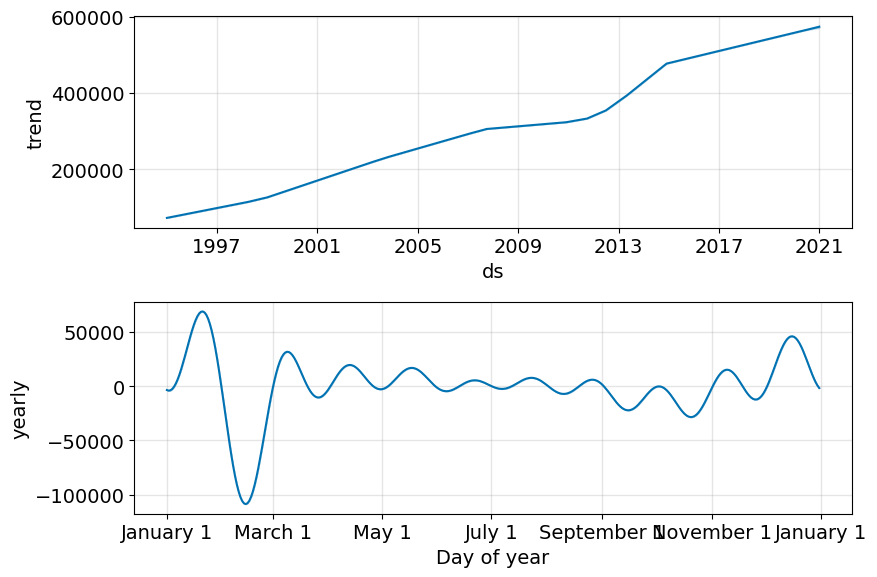

In [137]:
plt2 = model.plot_components(forecast)

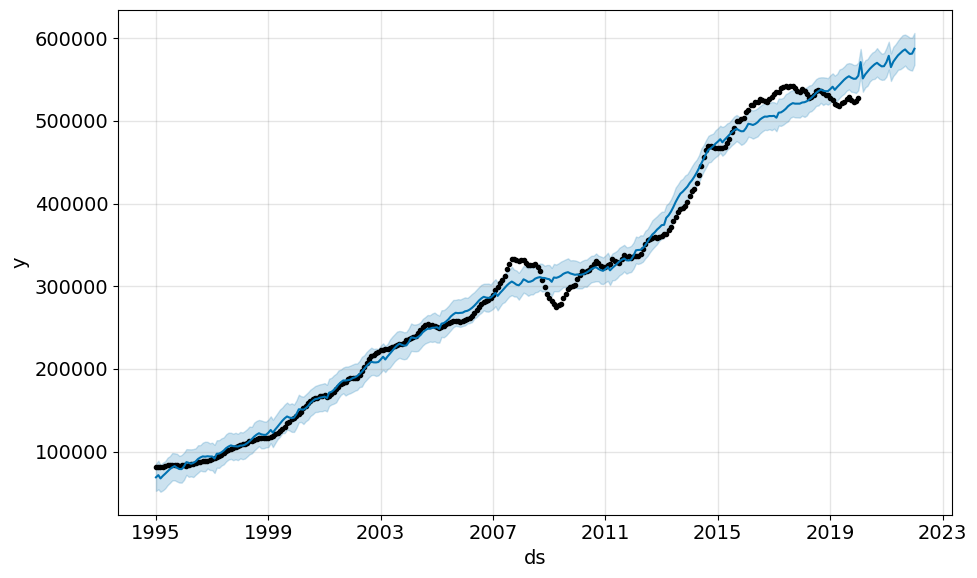

In [138]:
future2 = model.make_future_dataframe(periods=24, freq='M')

forecast2 = model.predict(future2)

# Visualise the prediction
fig1 = model.plot(forecast2)

In [139]:
forecast2.head(5)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1995-01-01 71,868.83   52,451.80   85,246.12    71,868.83    71,868.83   
1 1995-02-01 72,962.35   54,435.20   89,066.04    72,962.35    72,962.35   
2 1995-03-01 73,950.04   51,428.87   83,885.93    73,950.04    73,950.04   
3 1995-04-01 75,043.57   53,113.21   86,664.26    75,043.57    75,043.57   
4 1995-05-01 76,101.81   55,507.39   88,365.18    76,101.81    76,101.81   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -2,942.39             -2,942.39             -2,942.39 -2,942.39   
1       -1,378.11             -1,378.11             -1,378.11 -1,378.11   
2       -6,384.56             -6,384.56             -6,384.56 -6,384.56   
3       -4,364.36             -4,364.36             -4,364.36 -4,364.36   
4       -2,828.21             -2,828.21             -2,828.21 -2,828.21   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -2,942.39     -2,942.39                  0.00   
1     -1,378.11     -1,378.11                  0.00   
2     -6,384.56     -6,384.56                  0.00   
3     -4,364.36     -4,364.36                  0.00   
4     -2,828.21     -2,828.21                  0.00   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                        0.00                        0.00 68,926.43  
1                        0.00                        0.00 71,584.24  
2                        0.00                        0.00 67,565.48  
3                        0.00                        0.00 70,679.21  
4                        0.00                        0.00 73,273.60

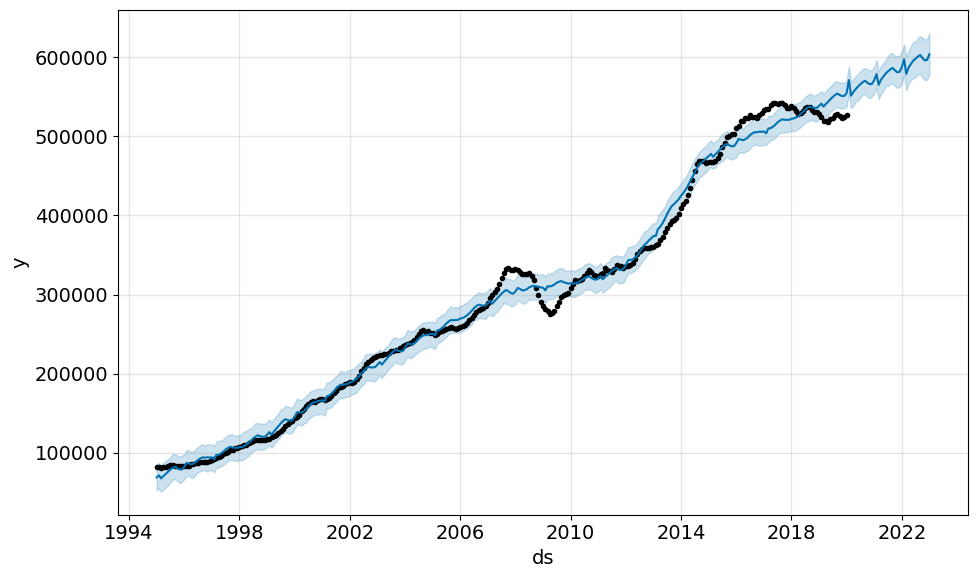

In [140]:
future3 = model.make_future_dataframe(periods=36, freq='M')

forecast3 = model.predict(future3)

# Visualise the prediction
fig1 = model.plot(forecast3)

In [141]:
forecast3.head(5)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1995-01-01 71,868.83   52,468.52   85,503.72    71,868.83    71,868.83   
1 1995-02-01 72,962.35   55,017.77   87,388.50    72,962.35    72,962.35   
2 1995-03-01 73,950.04   50,746.65   83,651.39    73,950.04    73,950.04   
3 1995-04-01 75,043.57   53,497.74   87,264.36    75,043.57    75,043.57   
4 1995-05-01 76,101.81   56,384.05   89,860.79    76,101.81    76,101.81   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -2,942.39             -2,942.39             -2,942.39 -2,942.39   
1       -1,378.11             -1,378.11             -1,378.11 -1,378.11   
2       -6,384.56             -6,384.56             -6,384.56 -6,384.56   
3       -4,364.36             -4,364.36             -4,364.36 -4,364.36   
4       -2,828.21             -2,828.21             -2,828.21 -2,828.21   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -2,942.39     -2,942.39                  0.00   
1     -1,378.11     -1,378.11                  0.00   
2     -6,384.56     -6,384.56                  0.00   
3     -4,364.36     -4,364.36                  0.00   
4     -2,828.21     -2,828.21                  0.00   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                        0.00                        0.00 68,926.43  
1                        0.00                        0.00 71,584.24  
2                        0.00                        0.00 67,565.48  
3                        0.00                        0.00 70,679.21  
4                        0.00                        0.00 73,273.60

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_y8zzhl/fqcpriak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_y8zzhl/xgcd0dex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83978', 'data', 'file=/tmp/tmpe_y8zzhl/fqcpriak.json', 'init=/tmp/tmpe_y8zzhl/xgcd0dex.json', 'output', 'file=/tmp/tmpe_y8zzhl/prophet_modelepf7gxl0/prophet_model-20230618204823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


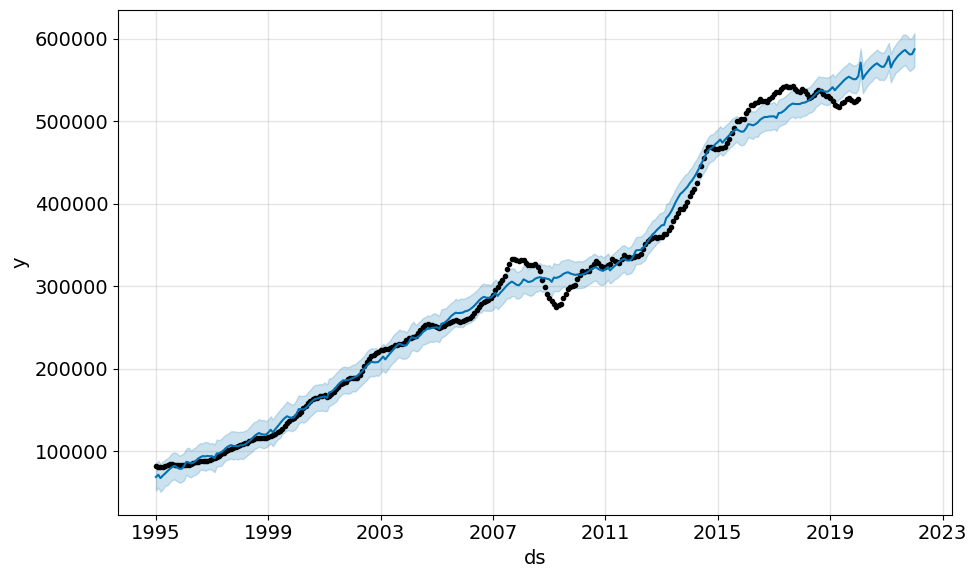

In [142]:
# Prepare the
model_df_england = pd.DataFrame(england_mean_price).reset_index()
model_df_england = model_df_england.rename(columns={'date': 'ds', 'average_price': 'y'})

# Initialise the model and make predictions
model_england = Prophet()
model_england.fit(model_df)

future_england = model_england.make_future_dataframe(periods=24, freq='M')

forecast_england = model_england.predict(future_england)

# Visualise the prediction
fig1 = model.plot(forecast_england)

In [143]:
forecast_england.head(5)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1995-01-01 71,868.83   52,393.05   84,678.48    71,868.83    71,868.83   
1 1995-02-01 72,962.35   56,048.77   88,592.69    72,962.35    72,962.35   
2 1995-03-01 73,950.04   50,990.42   84,803.95    73,950.04    73,950.04   
3 1995-04-01 75,043.57   54,013.85   87,703.63    75,043.57    75,043.57   
4 1995-05-01 76,101.81   58,427.65   89,695.15    76,101.81    76,101.81   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -2,942.39             -2,942.39             -2,942.39 -2,942.39   
1       -1,378.11             -1,378.11             -1,378.11 -1,378.11   
2       -6,384.56             -6,384.56             -6,384.56 -6,384.56   
3       -4,364.36             -4,364.36             -4,364.36 -4,364.36   
4       -2,828.21             -2,828.21             -2,828.21 -2,828.21   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -2,942.39     -2,942.39                  0.00   
1     -1,378.11     -1,378.11                  0.00   
2     -6,384.56     -6,384.56                  0.00   
3     -4,364.36     -4,364.36                  0.00   
4     -2,828.21     -2,828.21                  0.00   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                        0.00                        0.00 68,926.43  
1                        0.00                        0.00 71,584.24  
2                        0.00                        0.00 67,565.48  
3                        0.00                        0.00 70,679.21  
4                        0.00                        0.00 73,273.60

In [144]:
model_df1 = model_df.copy()
model_df1.set_index('ds',inplace=True)
model_df1.head()

y
ds                  
1995-01-01 81,906.42
1995-02-01 81,527.97
1995-03-01 81,349.27
1995-04-01 81,432.52
1995-05-01 82,277.30

<Axes: xlabel='ds'>

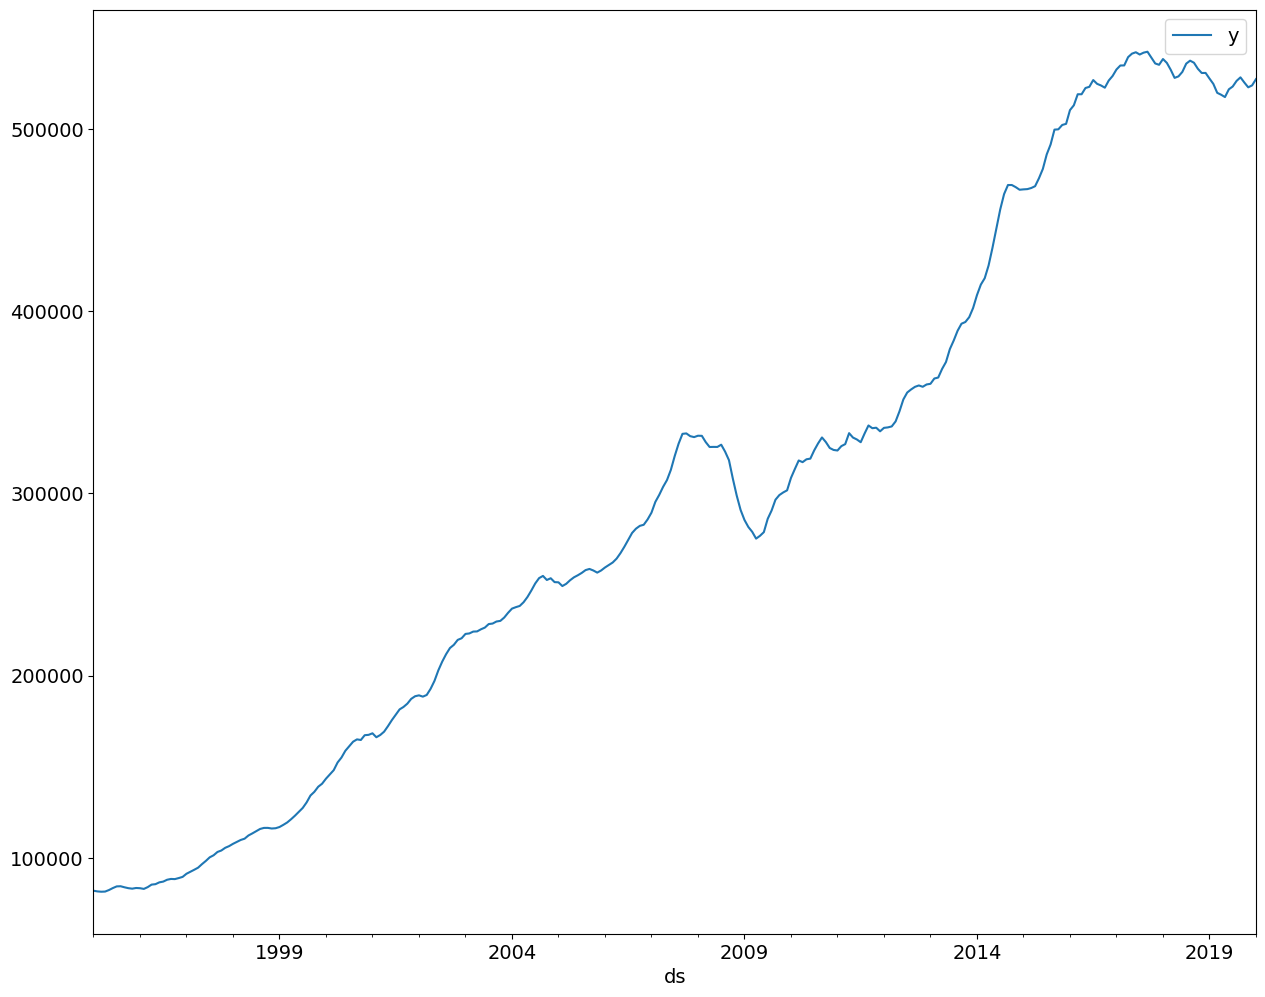

In [145]:
model_df1.plot()

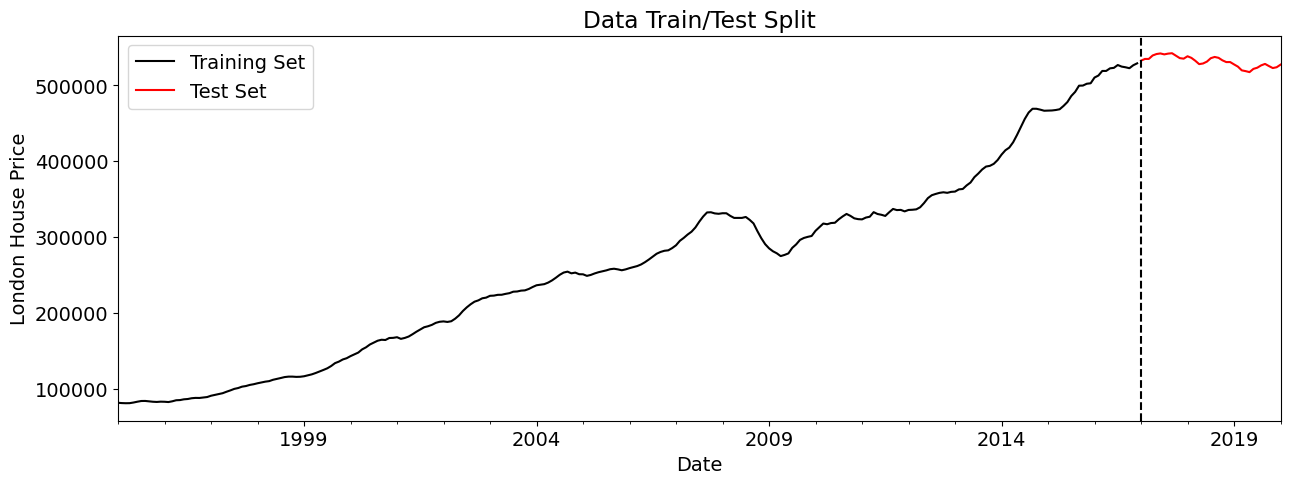

In [146]:
df_train = model_df1.loc[model_df1.index < '01-01-2017']
df_test = model_df1.loc[model_df1.index >= '01-01-2017']
# df_train = model_df1[model_df1.index < pd.to_datetime("2017-01-01", format='%Y-%m-%d')]
# df_test = model_df1[model_df1.index > pd.to_datetime("2017-01-01", format='%Y-%m-%d')]

fig, ax = plt.subplots(figsize=(15, 5))

df_train.plot(ax=ax, label='Training Set' , color = "black")
df_test.plot(ax=ax, label='Test Set' , color = "red")

plt.ylabel('London House Price')
plt.xlabel('Date')

ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.title('Data Train/Test Split')
# plt.xticks(rotation=45)
plt.show()

# Check for stationarity of time series


In [147]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

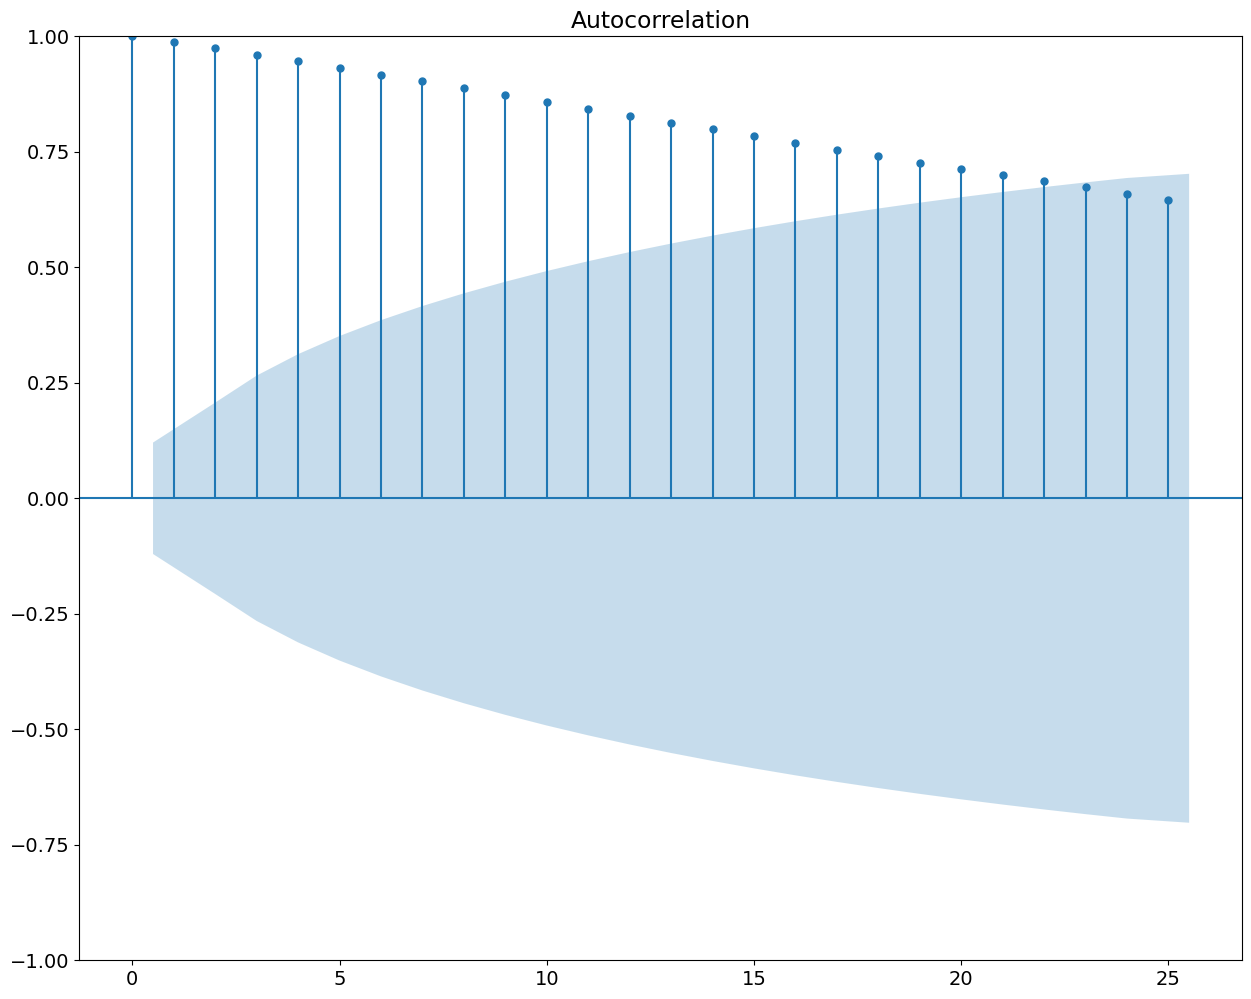

In [148]:
#@title Method #1: time series plot

acf_original = plot_acf(df_train )

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



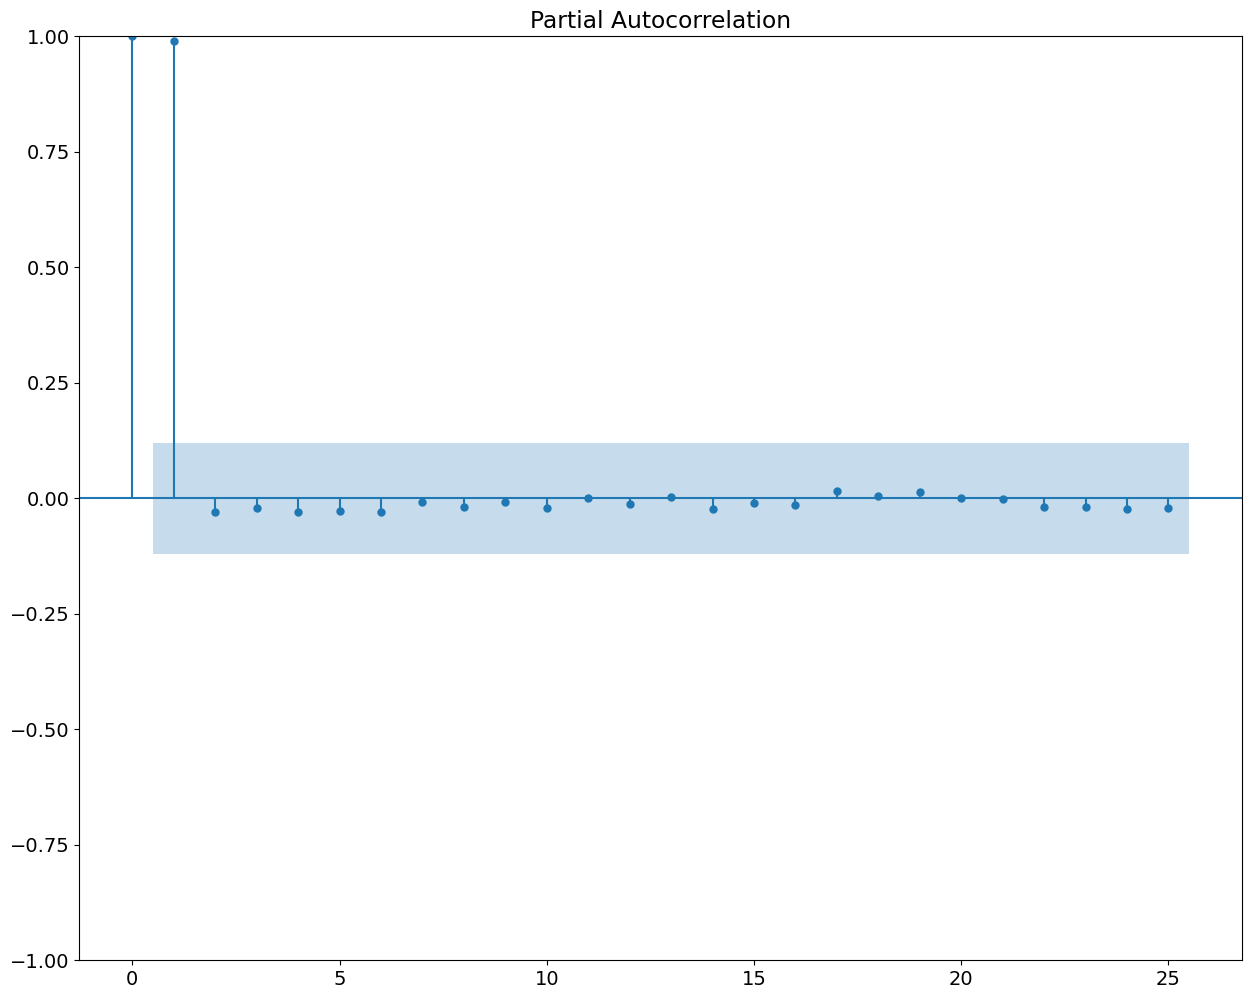

In [149]:
#@title Method #2: ACF plot and PACF plot

pacf_original = plot_pacf(df_train )

In [150]:
#@title Method3: ADF test

adf_test = adfuller(df_train )
print(f'p-value: {adf_test[1]}')

p-value: 0.9965553008257501


<Axes: xlabel='ds'>

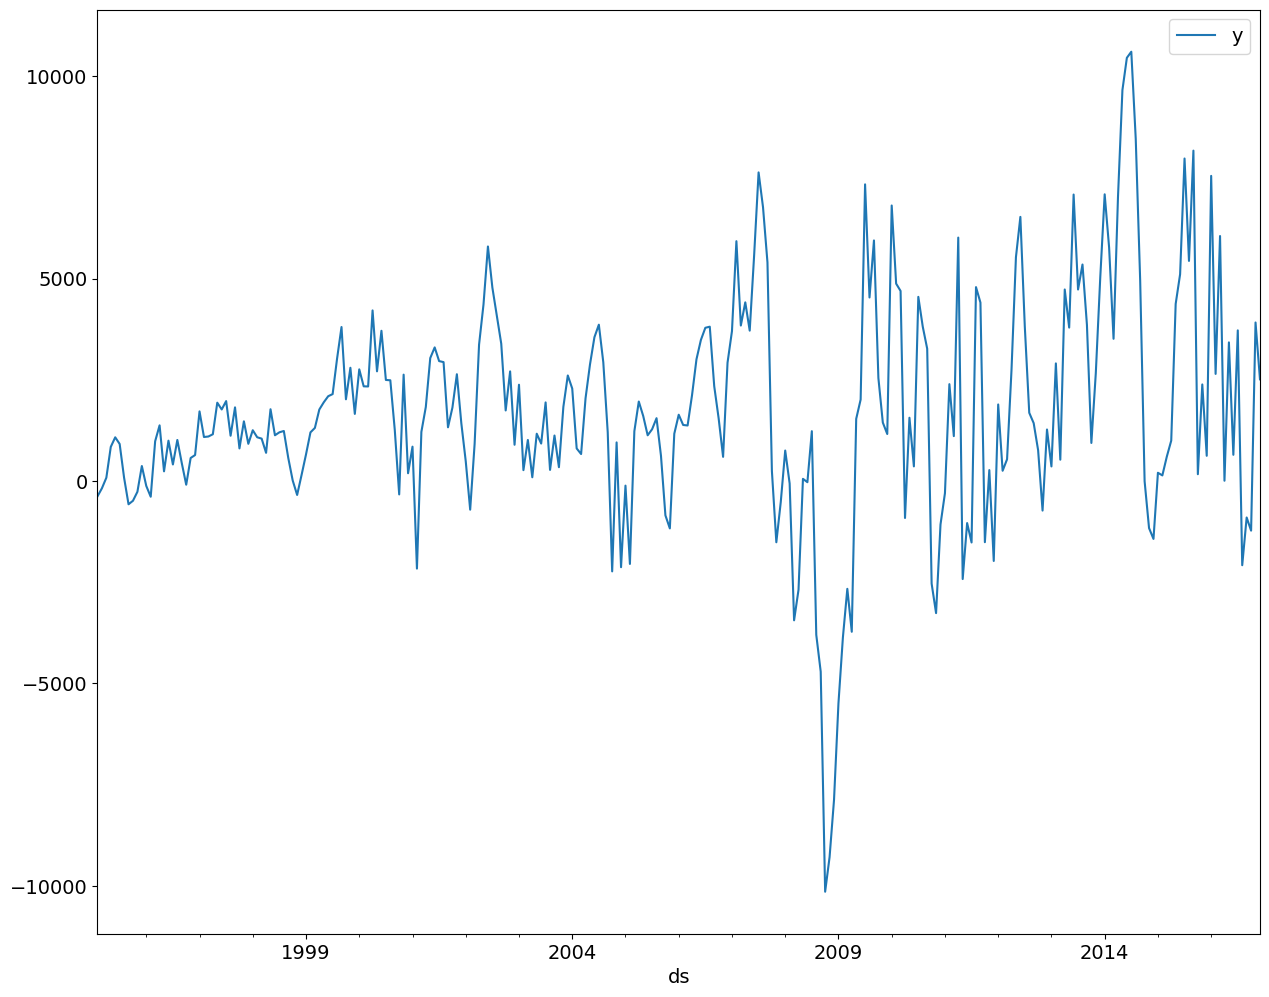

In [151]:
#@title Transform to stationary: differencing

df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



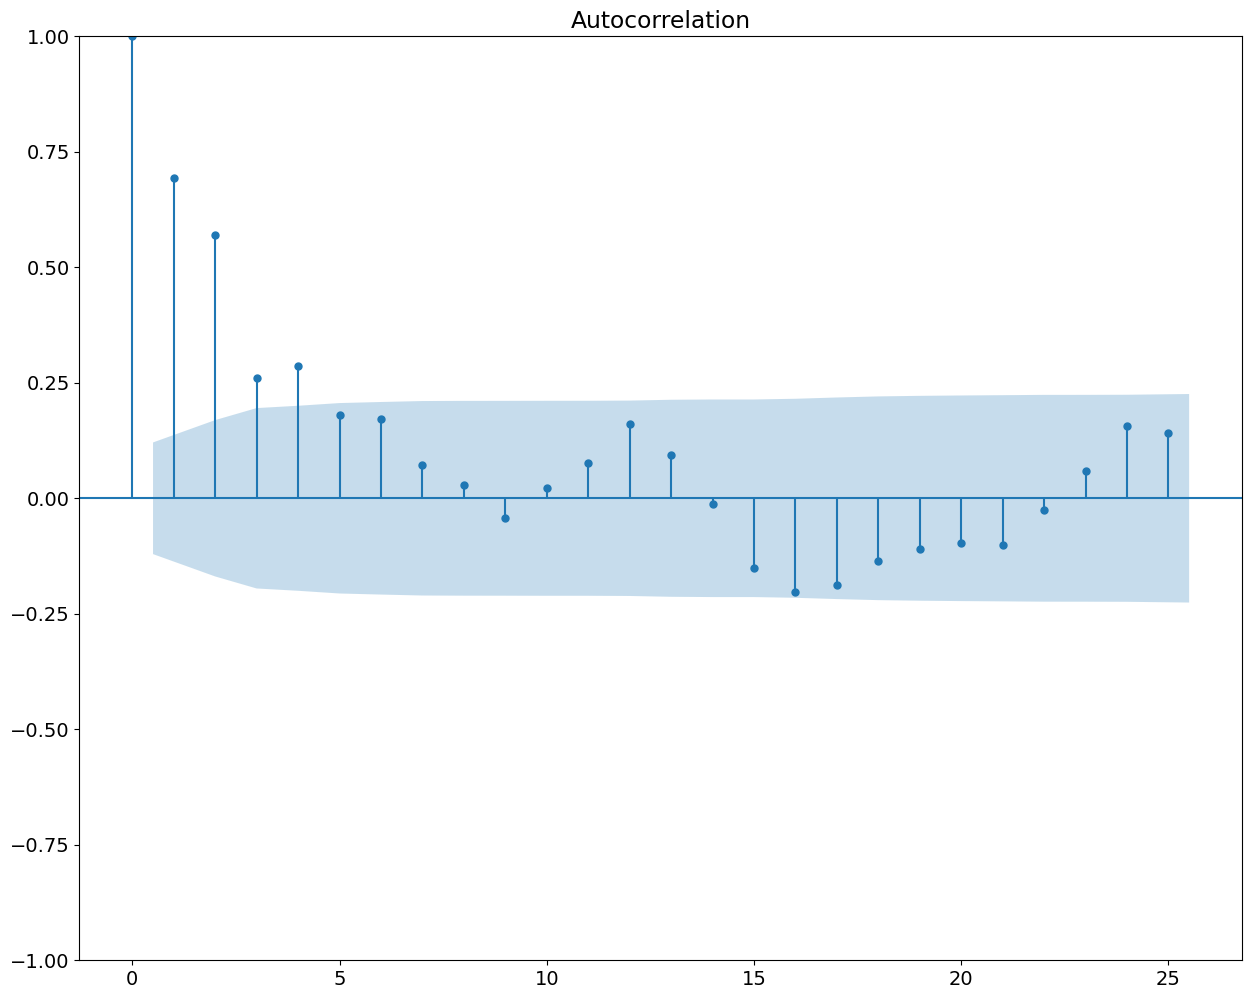

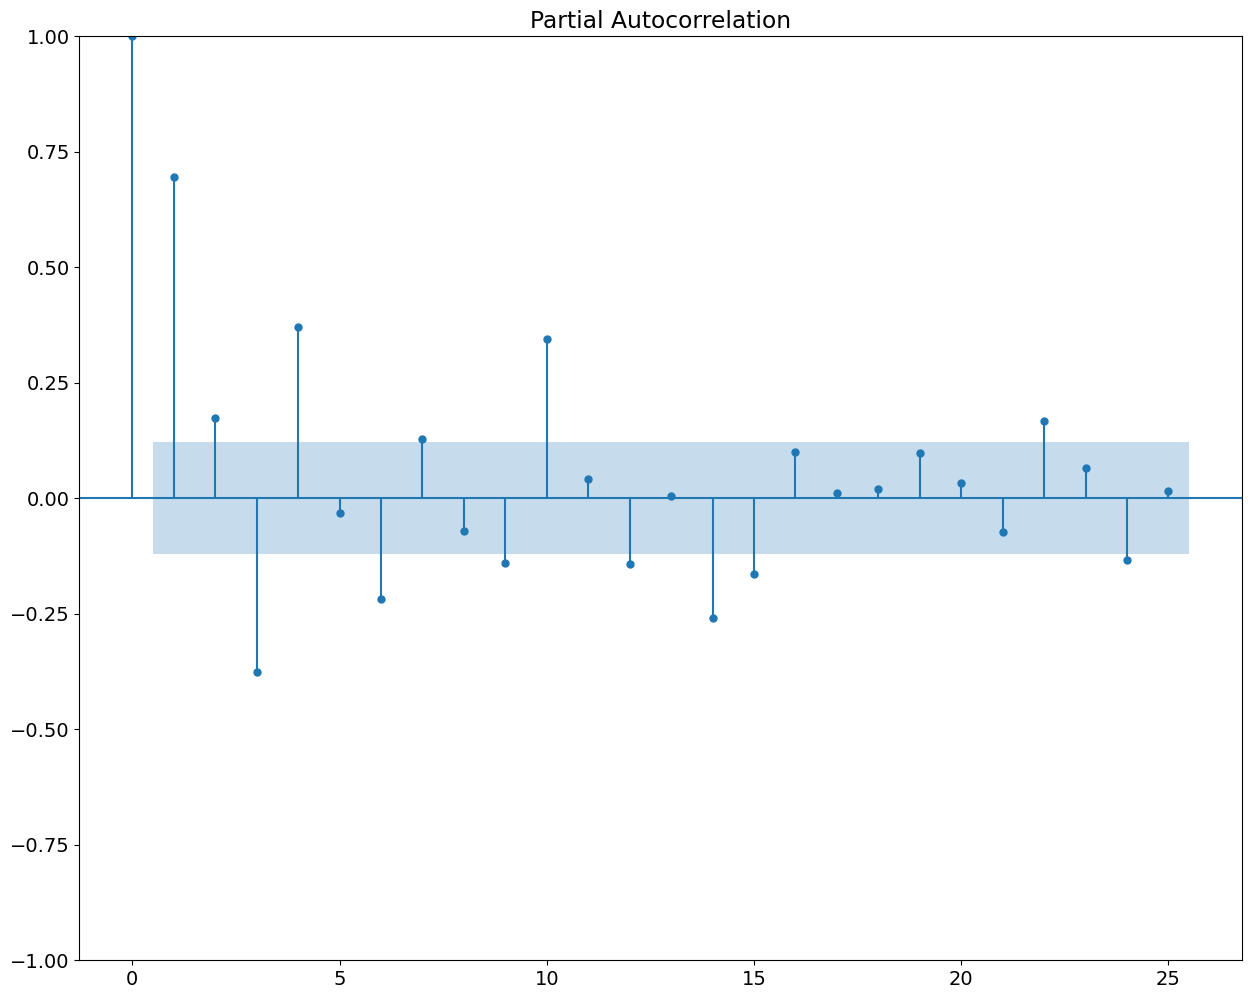

In [152]:
#@title Check again
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [153]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.000988293790094351


In [154]:
#@title Step 2: Determine ARIMA models parameters p, q
model = ARIMA(df_train , order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  264
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2462.512
Date:                Sun, 18 Jun 2023   AIC                           4931.024
Time:                        20:48:28   BIC                           4941.740
Sample:                    01-01-1995   HQIC                          4935.330
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1790      0.006     30.400      0.000       0.167       0.190
ar.L2          0.1581      0.009     17.738      0.000       0.141       0.176
sigma2      7.623e+06   5.39e-11   1.42e+17      0.0

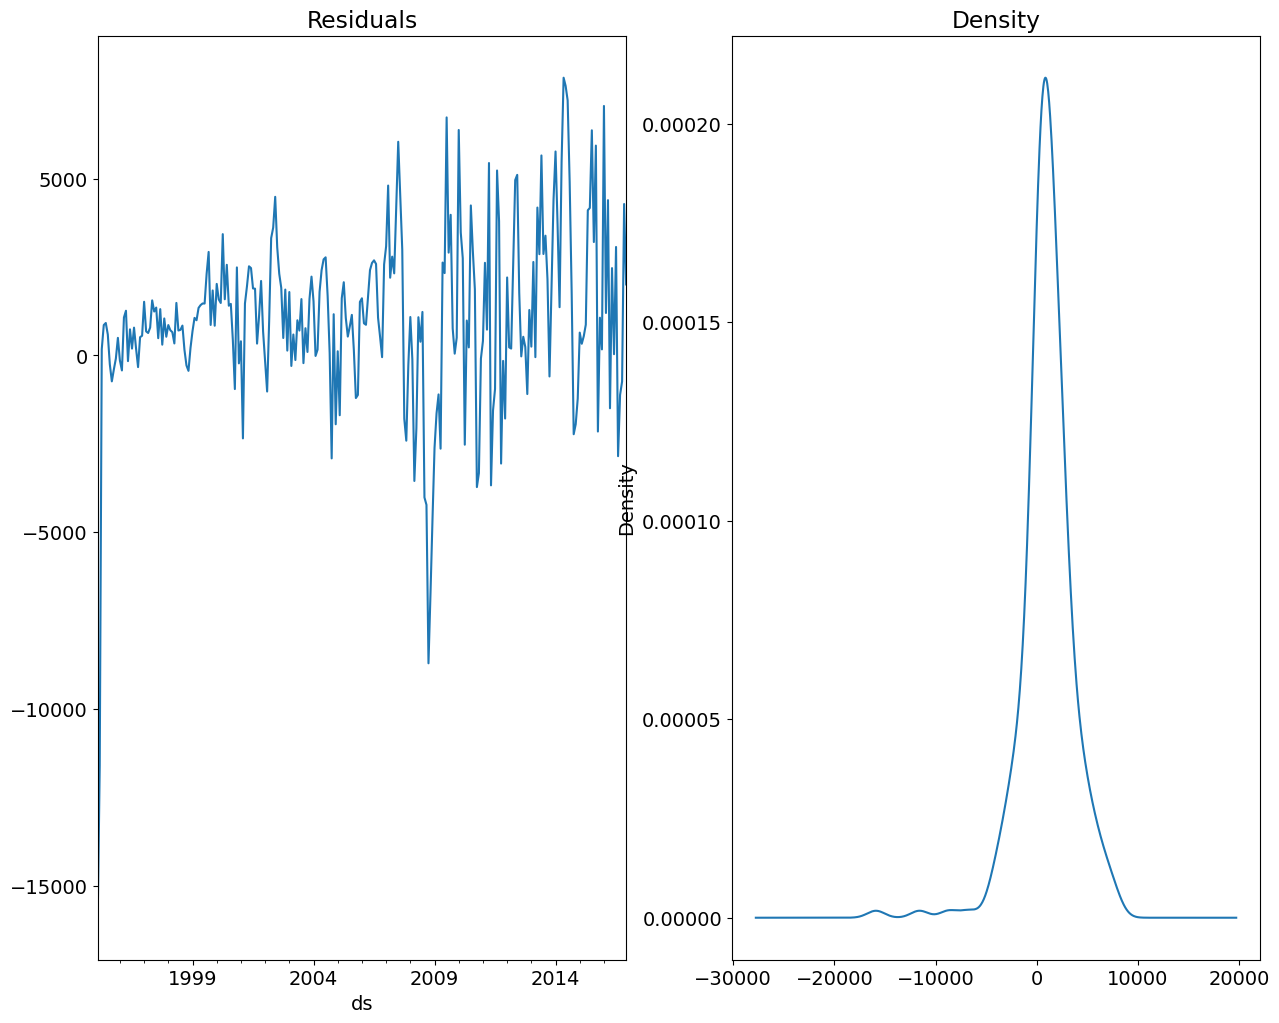

In [155]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



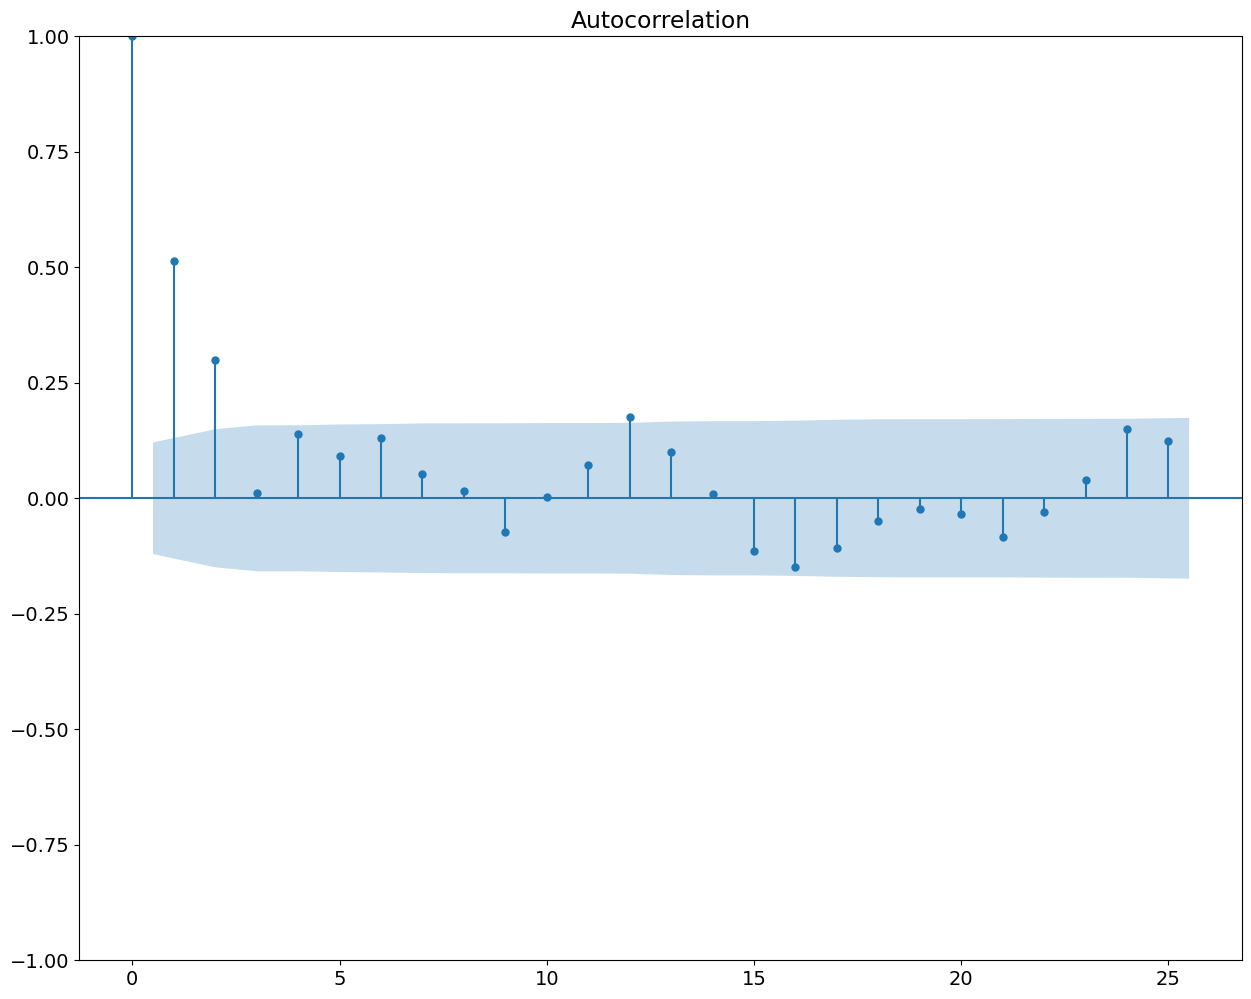

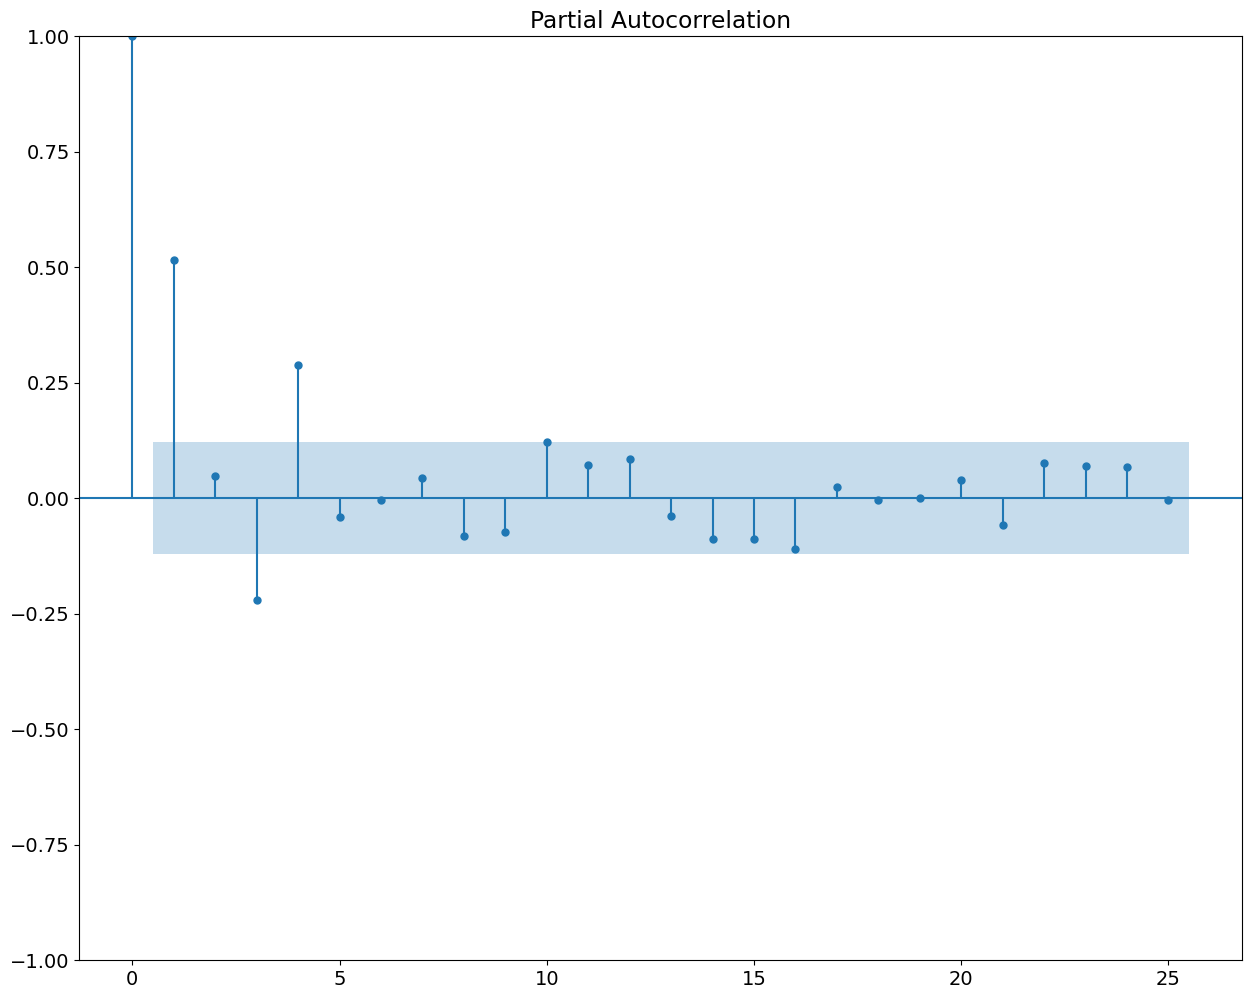

In [156]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<Axes: xlabel='ds'>

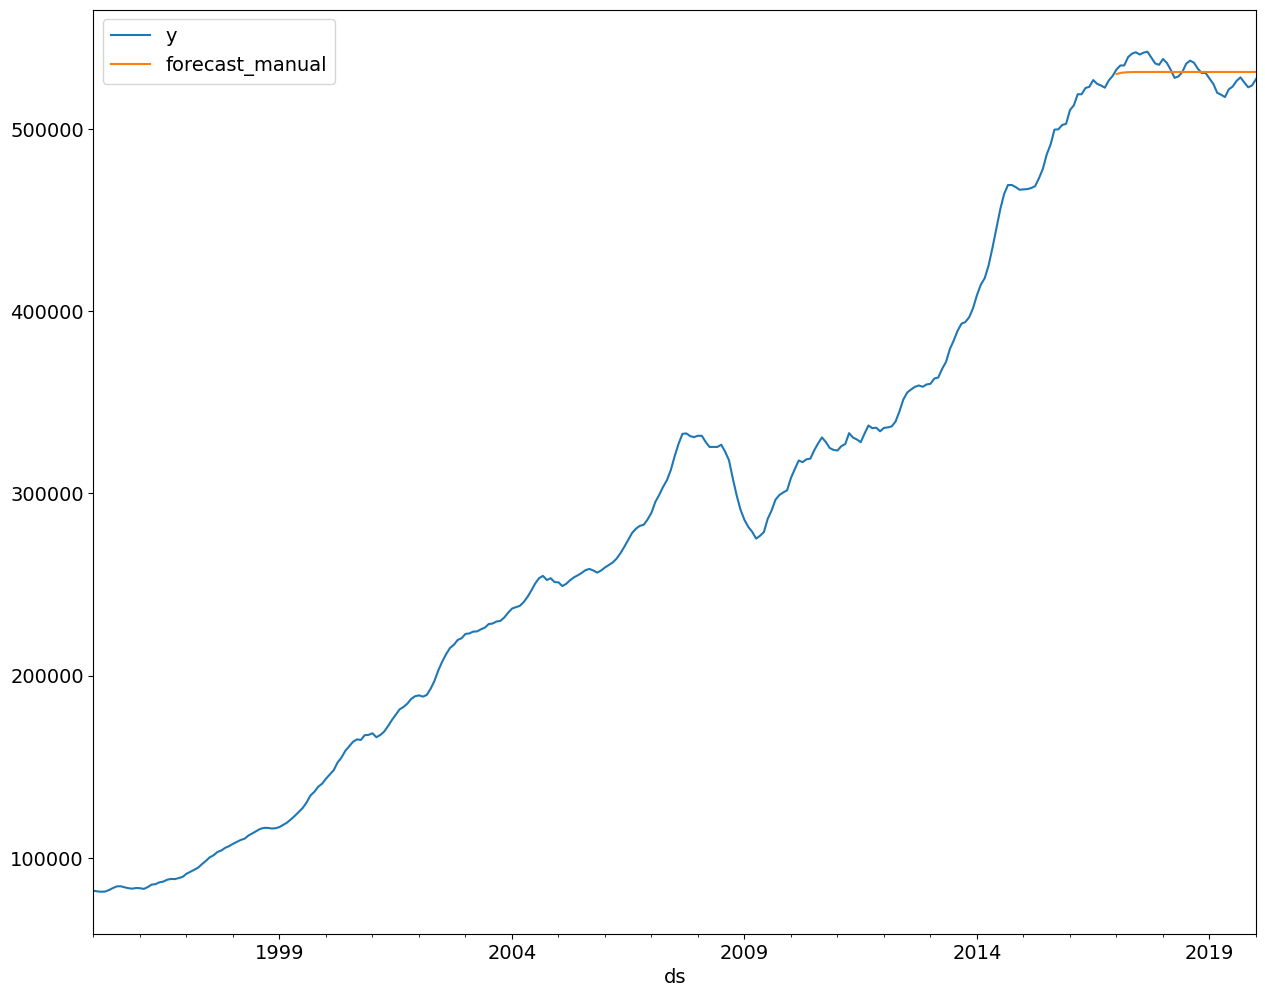

In [157]:
forecast_test = model_fit.forecast(len(df_test))
model_df1['forecast_manual'] = [None]*len(df_train) + list(forecast_test)
model_df1.plot()

In [158]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [159]:
#@title Auto-fit the ARIMA model

import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True)

In [160]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -2439.545
Date:                Sun, 18 Jun 2023   AIC                           4887.090
Time:                        20:48:50   BIC                           4901.378
Sample:                    01-01-1995   HQIC                          4892.832
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1207.4489    172.089      7.016      0.000     870.160    1544.738
ar.L1          0.1412      0.007     20.799      0.000       0.128       0.154
ar.L2          0.1049      0.010     10.059      0.000       0.084       0.125
sigma2      6.464e+06      0.006   1.02e+09      0.000    6.46e+06    6.46e+06
===================================================================================
Ljung-Box (L1) (Q):                  82.44   Jarque-Bera (JB):               163.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.54e+24. Standard errors may be unstable.
"""

<Axes: xlabel='ds'>

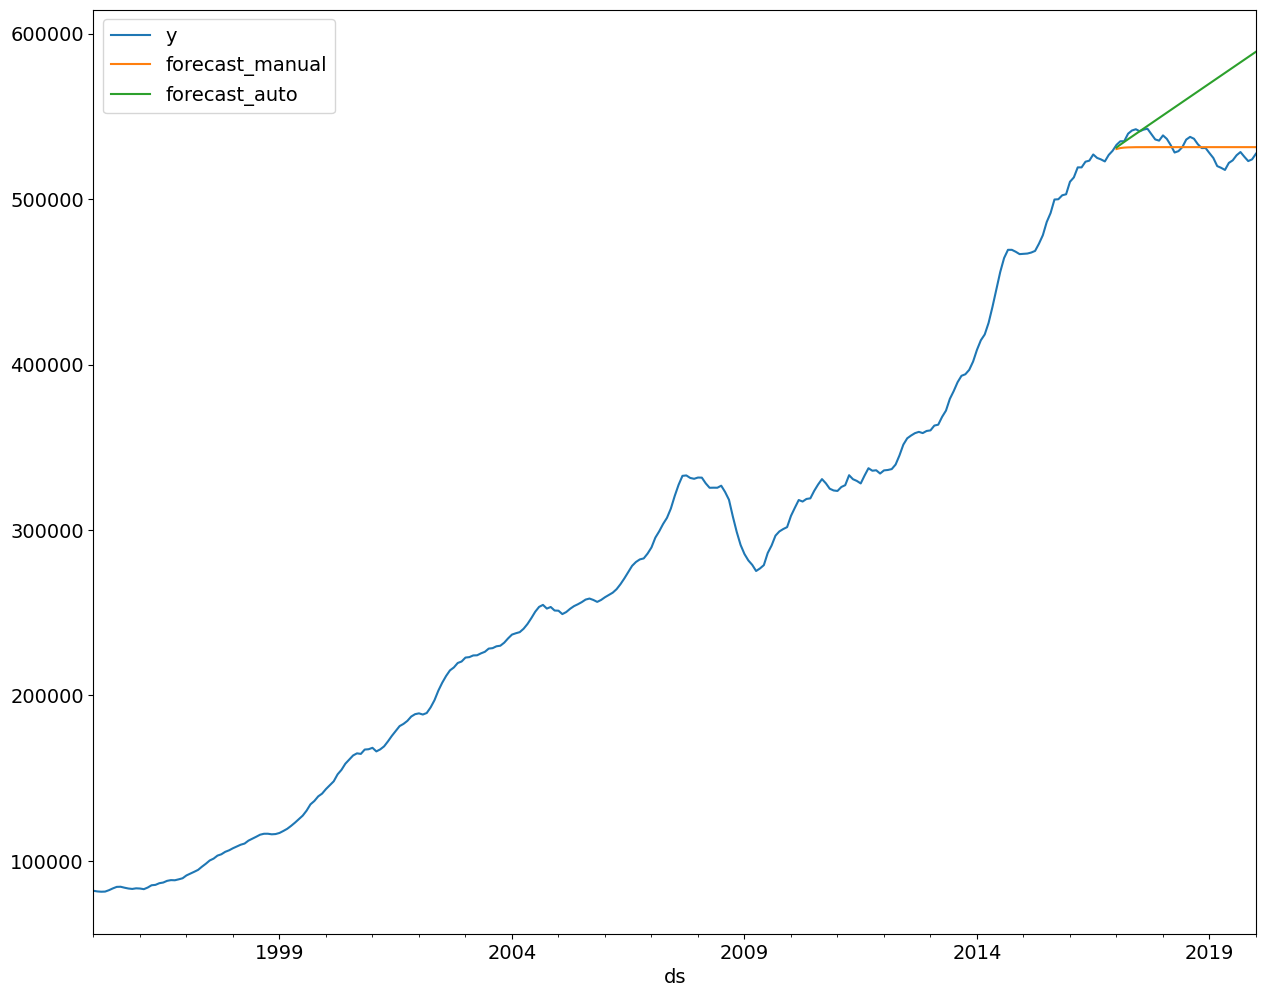

In [161]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
model_df1['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

model_df1.plot()

In [162]:
#END

<div class="alert alert-block alert-success">
<p><b>  Arian Azmoudeh </b></p>
<p> https://www.linkedin.com/in/arianazmoudeh

</div>

<div class="alert alert-block alert-danger">
<p><b>One small positive thought can change your whole day :)

<p>Be positive. Be true. Be kind:)

</div>

<p>Thank you very much for your attention

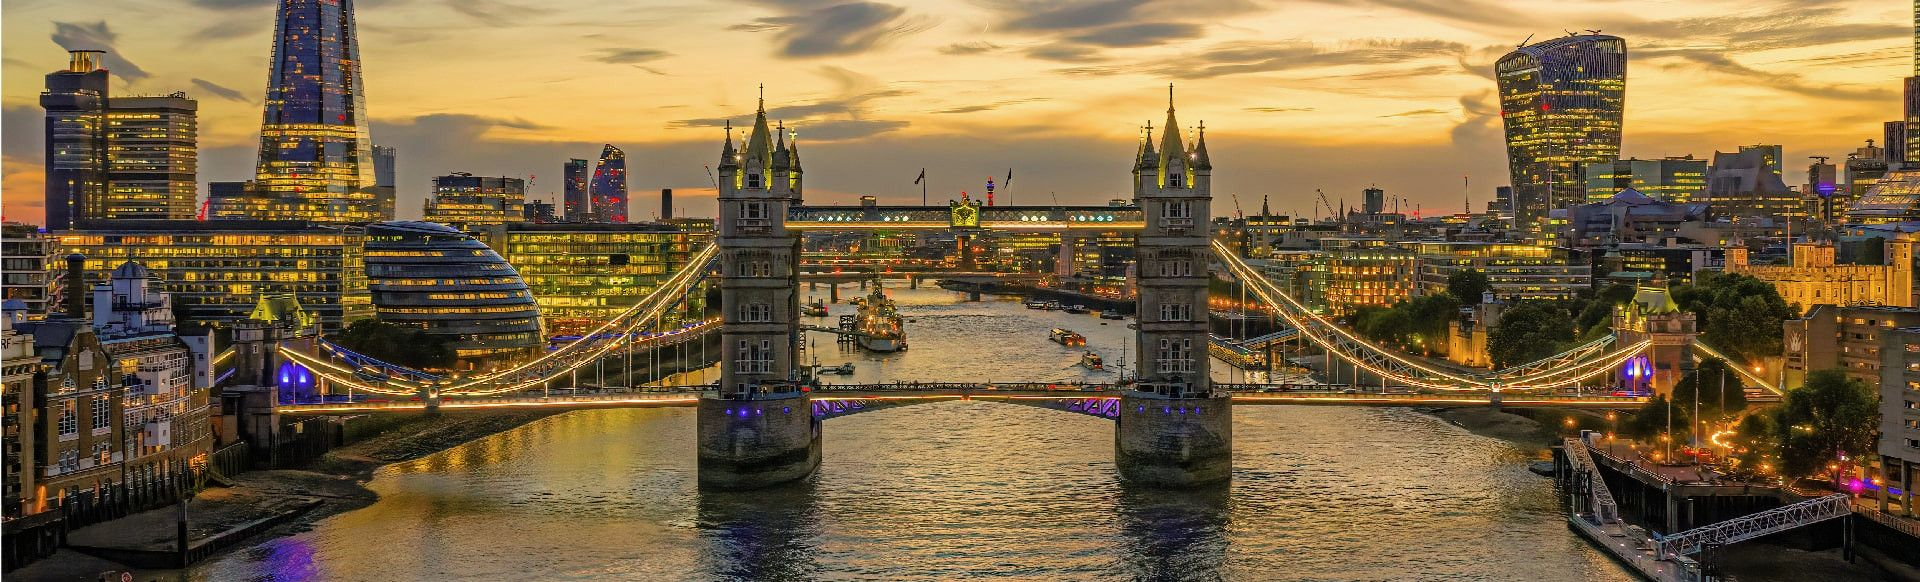